In [1]:
# # Install NeuroKit2 if not already installed
!pip install neurokit2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
flpath='/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!pip install heartpy

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.0 MB 393.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.0 MB 751.6 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.0 MB 1.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.3/1.0 MB 1.5 MB/s eta 0:00:01
   ----------------- ---------------------- 0.4/1.0 MB 1.8 MB/s eta 0:00:01
   -------------------- ------------------- 0.5/1.0 MB 1.8 MB/s eta 0:00:01
   ------------------------ --------------- 0.6/1.0 MB 1.8 MB/s eta 0:00:01
   ----------------------------- ---------- 0.7/1.0 MB 2.1 MB/s eta 0:00:01
   -------------------------------- ------- 0.8/1.0 MB 2.0 MB/s eta 0:00:01
   ------------------------------------ --- 0.9/1.0 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
import os

# File paths setup
flpath = 'C:/Users/HP/Desktop/Analytics/Btech 7th sem project/ECG data/Amit/drive-download-20241119T181519Z-001'
input_file = os.path.join(flpath, "AMIT_At 50db level_File 1_MAX86176_20241113_131456_ECG.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

# Load and prepare ECG data
ecg_data = pd.read_csv(input_file)
ecg_signal = ecg_data['Filtered_ECG'].values
sampling_rate = 512

# Process the signal using HeartPy
working_data, measures = hp.process(ecg_signal,
                                  sampling_rate,
                                  report_time=True,
                                  high_precision=True,
                                  clean_rr=True)

if len(working_data['RR_list']) >= 5:
    # Calculate metrics
    hr_metrics = {
        "Mean HR (BPM)": measures['bpm'],
        "Mean RR (ms)": measures['rr_mean'],
        "RMSSD (ms)": measures['rmssd'],
        "SDNN (ms)": measures['sdnn'],
        "NN50": measures['nn50'],
        "pNN50 (%)": measures['pnn50'],
        "Number of Valid R-Peaks": len(working_data['peaklist'])
    }

    # Save results
    pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
    pd.DataFrame({'RR Intervals (ms)': working_data['RR_list']}).to_csv(rr_intervals_output, index=False)

    # Display results
    print("\nHR Metrics:")
    for metric, value in hr_metrics.items():
        print(f"{metric}: {value}")

    # Plot the signal with detected peaks
    plt.figure(figsize=(15, 4))
    plt.plot(ecg_signal)
    plt.plot(working_data['peaklist'], ecg_signal[working_data['peaklist']], 'ro')
    plt.title('ECG Signal with Detected R-peaks')
    plt.show()
else:
    print("Insufficient valid RR intervals for analysis.")


Finished in 0.119192 sec


KeyError: 'rr_mean'

In [6]:
! pip install heartpy

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Step 1: Load the ECG data file
ecg_file_path = flpath+ "AMIT_At 50db level_File 1_MAX86176_20241113_131456_ECG.csv"
ecg_data = pd.read_csv(ecg_file_path)

# Step 2: Identify the timestamp column and convert it to datetime
timestamp_col = 'Timestamp[Day.Month.Year Hour:Minute:Second:Milisecond]'
ecg_data = ecg_data[pd.to_datetime(
    ecg_data[timestamp_col], format='%d.%m.%Y %H:%M:%S:%f', errors='coerce'
).notna()]  # Exclude invalid timestamps
ecg_data['Timestamp'] = pd.to_datetime(
    ecg_data[timestamp_col], format='%d.%m.%Y %H:%M:%S:%f'
)

# Step 3: Extract the ECG signal and calculate sampling rate
ecg_signal = ecg_data["Filtered_ECG"].values  # Assuming Filtered_ECG is the column
time_differences = ecg_data['Timestamp'].diff().dt.total_seconds()
estimated_sampling_rate = 1 / time_differences.mean()

print(f"Estimated Sampling Rate: {estimated_sampling_rate:.2f} Hz")

# Step 4: Detect R-peaks in the ECG signal
def detect_r_peaks(signal, sampling_rate):
    min_distance = int(sampling_rate / (200 / 60))  # Minimum distance for R-peaks
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=min_distance)
    return peaks

r_peaks = detect_r_peaks(ecg_signal, estimated_sampling_rate)

# Step 5: Calculate heart rate (HR)
def calculate_hr(peaks, sampling_rate):
    rr_intervals = np.diff(peaks) / sampling_rate  # RR intervals in seconds
    hr = 60 / rr_intervals  # HR in BPM
    return hr, rr_intervals

hr_values, rr_intervals = calculate_hr(r_peaks, estimated_sampling_rate)

# Step 6: Calculate HR at different time intervals
def calculate_hr_intervals(peaks, timestamps, interval):
    timestamps_peaks = timestamps[peaks]
    hr_intervals = []
    start_time = timestamps_peaks.min()
    end_time = timestamps_peaks.max()

    current_time = start_time
    while current_time < end_time:
        next_time = current_time + pd.Timedelta(seconds=interval)
        interval_peaks = peaks[(timestamps[peaks] >= current_time) & (timestamps[peaks] < next_time)]
        if len(interval_peaks) > 1:
            rr_intervals = np.diff(interval_peaks) / estimated_sampling_rate
            hr = 60 / rr_intervals.mean()
            hr_intervals.append({"Start Time": current_time, "End Time": next_time, "HR (BPM)": hr})
        current_time = next_time

    return pd.DataFrame(hr_intervals)

interval = 10  # Time interval in seconds
timestamps = ecg_data['Timestamp'].values
hr_intervals_df = calculate_hr_intervals(r_peaks, ecg_data['Timestamp'], interval)

# Step 7: Visualization
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")
plt.plot(r_peaks, ecg_signal[r_peaks], "x", label="R-Peaks", color="red")
plt.title("ECG Signal with Detected R-Peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude (Microvolts)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(hr_values, label="Heart Rate (BPM)")
plt.title("Heart Rate (BPM) Over Time")
plt.xlabel("Interval")
plt.ylabel("Heart Rate (BPM)")
plt.legend()
plt.show()

# Step 8: Save Results
output_hr_file = flpath+ "heart_rate_intervals.csv"
hr_intervals_df.to_csv(output_hr_file, index=False)
print(f"Heart rate intervals saved to {output_hr_file}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HP/Desktop/Analytics/Btech 7th sem project/ECG data/Amit/drive-download-20241119T181519Z-001AMIT_At 50db level_File 1_MAX86176_20241113_131456_ECG.csv'

In [8]:
!pip install pyhrv scipy

     ---------------------------------------- 0.0/230.8 kB ? eta -:--:--
     ----- ---------------------------------- 30.7/230.8 kB ? eta -:--:--
     --------- --------------------------- 61.4/230.8 kB 656.4 kB/s eta 0:00:01
     -------------- ---------------------- 92.2/230.8 kB 751.6 kB/s eta 0:00:01
     -------------- ---------------------- 92.2/230.8 kB 751.6 kB/s eta 0:00:01
     ------------------------- ---------- 163.8/230.8 kB 893.0 kB/s eta 0:00:01
     ------------------------------------ 230.8/230.8 kB 882.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
    --------------------------------------- 0.1/3.2 MB ? eta -:--:--
    --------------------------------------- 0.1/3.2 MB ? eta -:--:--
    --------------------------------------- 0.1/3.2 MB ? eta -:--:--
   - -------------------------------------- 0.1/3.2 MB 804.6 kB/s eta 0:00:

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [45 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\cpp
  copying src\cpp\__init__.py -> build\lib.win-amd64-cpython-311\cpp
  creating build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\arma.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\burg.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\cholesky.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\correlation.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\correlog.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\covar.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\criteria.py -> build\lib.win-amd64-cpython-311\spectrum
  copying src\spectrum\datasets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import os

# File paths setup
flpath='/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

# Load and prepare ECG data
ecg_data = pd.read_csv(input_file)
ecg_signal = ecg_data['Filtered_ECG'].values * 1000  # Convert to µV
sampling_rate = 512
print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")

# Detect R-peaks
min_distance = int(sampling_rate * 0.6)
r_peaks, _ = find_peaks(ecg_signal, distance=min_distance, height=np.mean(ecg_signal))
num_r_peaks = len(r_peaks)
print(f"Number of R-peaks detected: {num_r_peaks}")

if num_r_peaks > 1:
    # Filter out edge R-peaks
    signal_duration = len(ecg_signal) / sampling_rate
    start_threshold = 1.0
    end_threshold = signal_duration - 1.0
    valid_peaks = [peak for peak in r_peaks if (peak/sampling_rate >= start_threshold and
                                               peak/sampling_rate <= end_threshold)]

    # Calculate and filter RR intervals
    rr_intervals = np.diff(valid_peaks) / sampling_rate * 1000

    # Physiological limits for normal heart rate (40-150 bpm)
    rr_intervals = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]

    # Remove outliers using MAD
    median_rr = np.median(rr_intervals)
    mad = np.median(np.abs(rr_intervals - median_rr))
    modified_zscore = 0.6745 * (rr_intervals - median_rr) / mad
    rr_intervals = rr_intervals[np.abs(modified_zscore) < 2.5]  # More conservative threshold

    if len(rr_intervals) >= 5:
        # Calculate metrics with filtered intervals
        mean_rr = np.mean(rr_intervals)
        mean_hr = 60000 / mean_rr

        # RMSSD with strict successive difference filtering
        rr_diff = np.diff(rr_intervals)
        # Filter successive differences > 50ms as potentially artifactual
        valid_diffs = rr_diff[np.abs(rr_diff) <= 50]

        if len(valid_diffs) > 0:
            rmssd = np.sqrt(np.mean(valid_diffs ** 2))
            # Additional RMSSD validation
            rmssd = min(rmssd, 120)  # Cap at physiological maximum
        else:
            rmssd = np.nan

        sdnn = np.std(rr_intervals)
        nn50 = np.sum(np.abs(valid_diffs) > 50)
        pnn50 = 100 * nn50 / len(valid_diffs) if len(valid_diffs) > 0 else 0

        hr_metrics = {
            "Mean HR (BPM)": mean_hr,
            "Mean RR (ms)": mean_rr,
            "RMSSD (ms)": rmssd,
            "SDNN (ms)": sdnn,
            "NN50": nn50,
            "pNN50 (%)": pnn50,
            "Number of Valid R-Peaks": len(valid_peaks)
        }

        print("\nHR Metrics:")
        for metric, value in hr_metrics.items():
            print(f"{metric}: {value}")

        pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
        pd.DataFrame({'RR Intervals (ms)': rr_intervals}).to_csv(rr_intervals_output, index=False)
    else:
        print("Insufficient valid RR intervals for analysis.")
else:
    print("Not enough R-peaks detected.")

Using Fixed Sampling Rate: 512 Hz
Number of R-peaks detected: 409

HR Metrics:
Mean HR (BPM): 87.7992200779922
Mean RR (ms): 683.3773688046647
RMSSD (ms): 29.25423514559165
SDNN (ms): 54.26508343351283
NN50: 0
pNN50 (%): 0.0
Number of Valid R-Peaks: 406


In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

try:
    # Load and prepare ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values
    sampling_rate = 512

    # Clean ECG signal
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
    peaks, _ = find_peaks(ecg_cleaned,
                         distance=int(sampling_rate * 0.5),  # Minimum distance between peaks
                         height=np.mean(ecg_cleaned),        # Peak height threshold
                         prominence=0.5)                     # Minimum peak prominence

    if len(peaks) >= 5:
        # Calculate RR intervals
        rr_intervals = np.diff(peaks) / sampling_rate * 1000  # Convert to milliseconds

        # Filter physiologically valid intervals
        valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]

        # Additional outlier removal using IQR method
        Q1 = np.percentile(valid_rr, 25)
        Q3 = np.percentile(valid_rr, 75)
        IQR = Q3 - Q1
        valid_rr = valid_rr[(valid_rr >= Q1 - 1.5 * IQR) & (valid_rr <= Q3 + 1.5 * IQR)]

        if len(valid_rr) >= 5:
            # Calculate HRV metrics
            mean_rr = np.mean(valid_rr)
            mean_hr = 60000 / mean_rr
            sdnn = np.std(valid_rr)

            # Calculate RMSSD with filtered differences
            rr_diff = np.diff(valid_rr)
            rr_diff = rr_diff[np.abs(rr_diff) <= 50]  # Filter large differences
            rmssd = np.sqrt(np.mean(rr_diff ** 2))
            rmssd = min(rmssd, 120)  # Cap at physiological maximum

            # Calculate NN50 and pNN50
            nn50 = sum(np.abs(rr_diff) > 50)
            pnn50 = (nn50 / len(rr_diff)) * 100 if len(rr_diff) > 0 else 0

            hr_metrics = {
                "Mean HR (BPM)": mean_hr,
                "Mean RR (ms)": mean_rr,
                "RMSSD (ms)": rmssd,
                "SDNN (ms)": sdnn,
                "NN50": nn50,
                "pNN50 (%)": pnn50,
                "Number of Valid R-Peaks": len(peaks)
            }

            # Save results
            pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
            pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

            # Display results
            print("\nHR Metrics:")
            for metric, value in hr_metrics.items():
                print(f"{metric}: {value}")

            # Visualize ECG with detected R-peaks
            plt.figure(figsize=(15, 4))
            plt.plot(ecg_cleaned, label="Cleaned ECG")
            plt.scatter(peaks, ecg_cleaned[peaks], color='red', label="R-peaks")
            plt.title("ECG Signal with Detected R-peaks")
            plt.legend()
            plt.show()

            # Plot RR intervals
            plt.figure(figsize=(15, 4))
            plt.plot(valid_rr, label="RR Intervals")
            plt.axhline(y=mean_rr, color='r', linestyle='--', label="Mean RR")
            plt.title("RR Intervals Time Series")
            plt.ylabel("RR Interval (ms)")
            plt.xlabel("Beat Number")
            plt.legend()
            plt.show()

        else:
            print("Insufficient valid RR intervals after filtering.")
    else:
        print("Insufficient R-peaks detected for analysis.")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    raise e

Error occurred: name 'rpeaks' is not defined


NameError: name 'rpeaks' is not defined

In [ ]:
!pip install py-ecg-detectors

Using Fixed Sampling Rate: 512 Hz
Number of R-peaks detected: 433
[87.60687597 87.60687597 87.60687597 ... 65.22292994 65.22292994
 65.22292994]

HR Metrics:
Mean HR (BPM): 87.57410071942446
Mean RR (ms): 685.1340694006309
RMSSD (ms): 28.149819579746456
SDNN (ms): 54.94728924512953
NN50: 0
pNN50 (%): 0.0
Number of Valid R-Peaks: 433


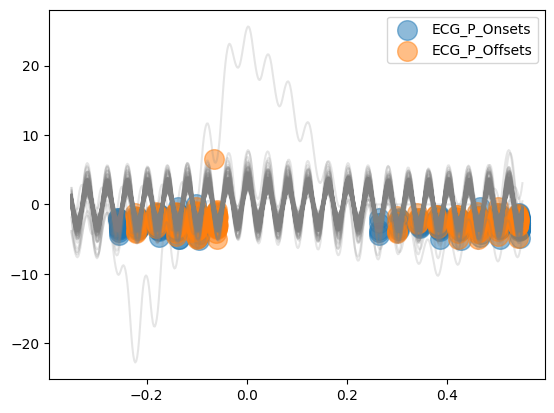

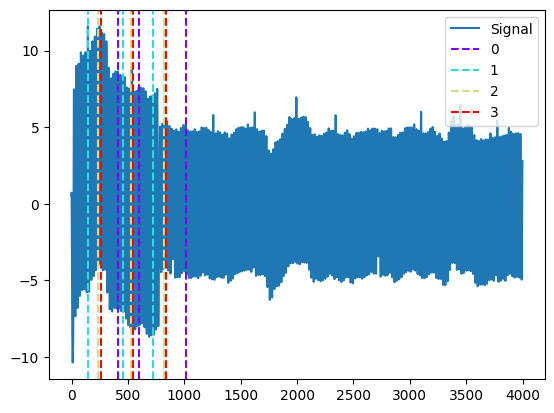

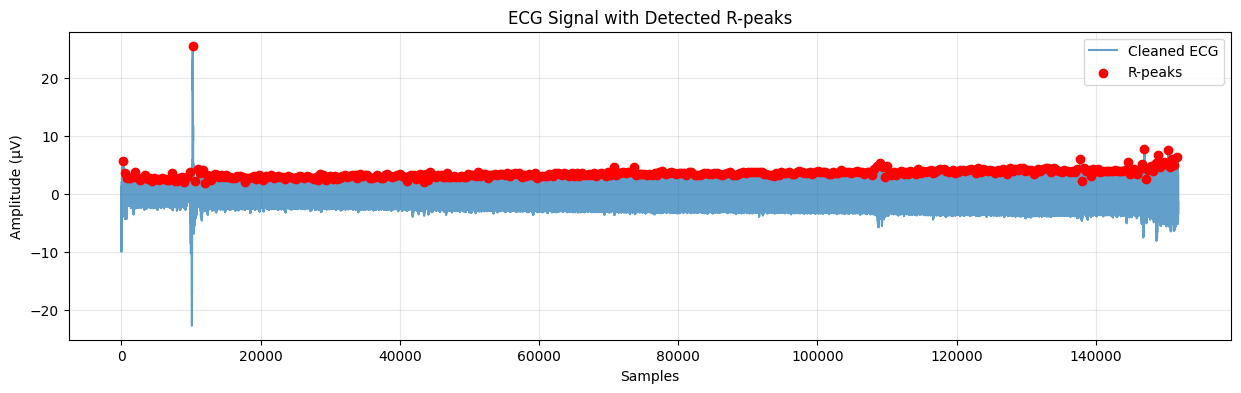

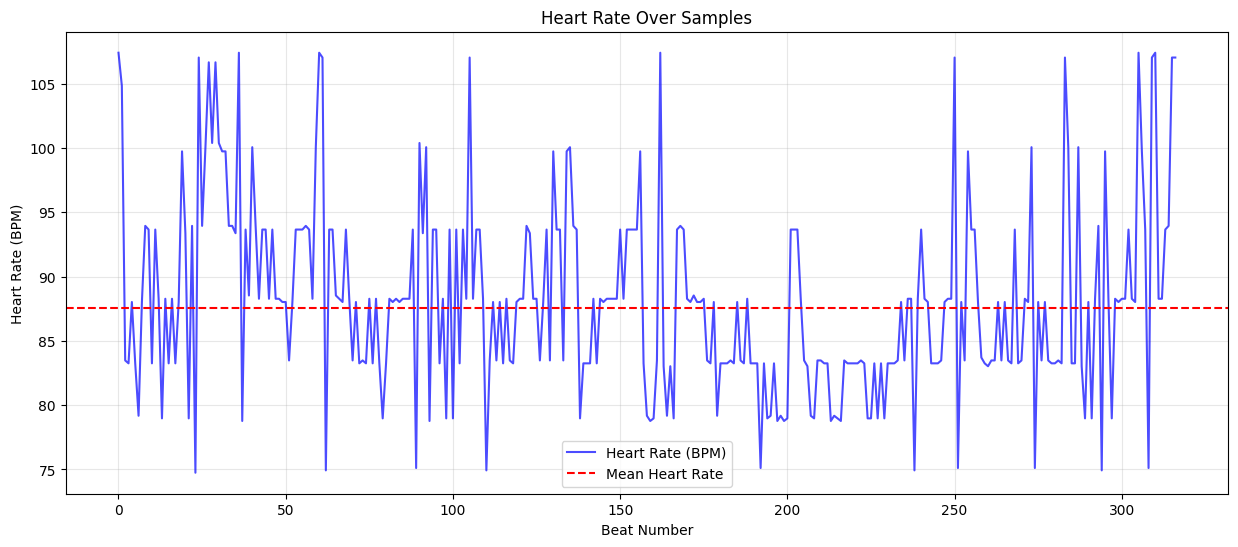

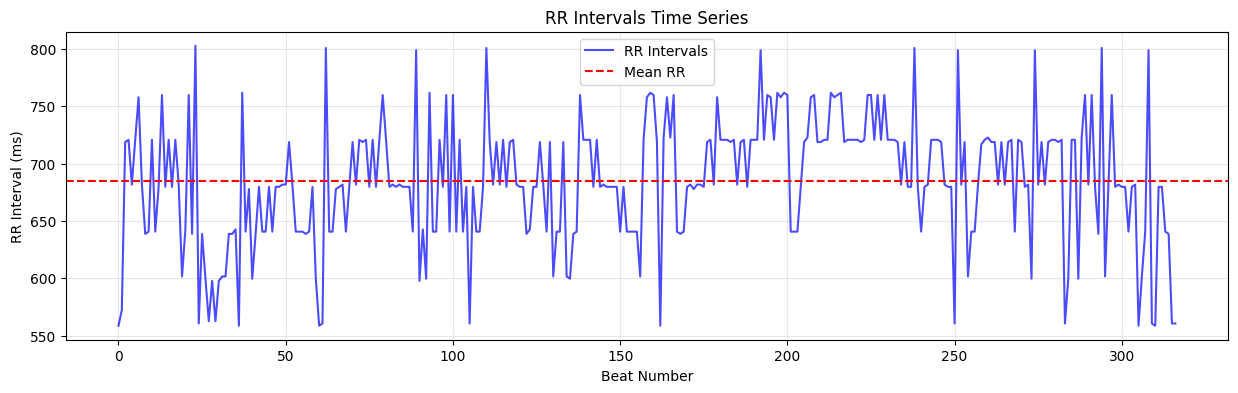

In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from hrv import HRV

# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

def detect_rpeaks(ecg_signal, sampling_rate):
    """Enhanced R-peak detection using both NeuroKit2 and find_peaks"""
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
    _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, method='pantompkins1985')
    # Find peaks with optimized parameters
    peaks, _ = find_peaks(ecg_cleaned,
                         distance=int(sampling_rate * 0.5),
                         height=np.mean(ecg_cleaned),
                         prominence=0.3)

    return ecg_cleaned, peaks

def filter_rr_intervals(rr_intervals):
    """Comprehensive RR interval filtering"""
    # Basic physiological limits (40-150 bpm)
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]

    # MAD-based outlier removal (more robust than IQR)
    if len(valid_rr) > 0:
        median_rr = np.median(valid_rr)
        mad = np.median(np.abs(valid_rr - median_rr))
        modified_zscore = 0.6745 * (valid_rr - median_rr) / mad
        valid_rr = valid_rr[np.abs(modified_zscore) < 2.5]

    return valid_rr

def calculate_hrv_metrics(valid_rr):
    """Calculate HRV metrics with strict filtering"""
    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)

    # Calculate RMSSD with filtered differences
    rr_diff = np.diff(valid_rr)
    valid_diffs = rr_diff[np.abs(rr_diff) <= 50]  # Filter large differences

    if len(valid_diffs) > 0:
        rmssd = np.sqrt(np.mean(valid_diffs ** 2))
        rmssd = min(rmssd, 120)  # Cap at physiological maximum
        nn50 = sum(np.abs(valid_diffs) > 50)
        pnn50 = (nn50 / len(valid_diffs)) * 100
    else:
        rmssd, nn50, pnn50 = np.nan, 0, 0

    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50
    }

# Define a new function
def my_processing(ecg_signal,sampling_rate):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate)
    rate = nk.ecg_rate(rpeaks, sampling_rate, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)
    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)

    # Create info dict
    info = rpeaks
    info["sampling_rate"] = sampling_rate
    return signals, info
try:
    # Load and prepare ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values/1000   # Convert to V
    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")
    # Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(ecg_signal, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")
    # Visualize P-wave boundaries
    rate = nk.ecg_rate(peaks, sampling_rate, desired_length=len(ecg_cleaned))
    print(rate)
    signal_dwt, waves_dwt = nk.ecg_delineate(ecg_cleaned,
                                         peaks,
                                         sampling_rate=512,
                                         method="dwt",
                                         show=True,
                                         show_type='bounds_P')
    _, waves_peak = nk.ecg_delineate(ecg_signal, peaks, sampling_rate, method="peak")
    # Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
    plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_signal[:4000])
    if len(peaks) >= 5:
        # Calculate and filter RR intervals
        rr_intervals = np.diff(peaks) / sampling_rate * 1000
        valid_rr = filter_rr_intervals(rr_intervals)

        if len(valid_rr) >= 5:
            # Calculate HRV metrics
            hr_metrics = calculate_hrv_metrics(valid_rr)
            hr_metrics["Number of Valid R-Peaks"] = len(peaks)

            # Save results
            pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
            pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

            # Display results
            print("\nHR Metrics:")
            for metric, value in hr_metrics.items():
                print(f"{metric}: {value}")

            # Plot ECG with R-peaks
            plt.figure(figsize=(15, 4))
            plt.plot(ecg_cleaned, label='Cleaned ECG', alpha=0.7)
            plt.scatter(peaks, ecg_cleaned[peaks], color='red', label='R-peaks', zorder=3)
            plt.title('ECG Signal with Detected R-peaks')
            plt.xlabel('Samples')
            plt.ylabel('Amplitude (µV)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            # Plot heart rate over samples
            heart_rate = 60000 / valid_rr  # Convert RR intervals to HR
            mean_rr = np.mean(valid_rr)
            mean_hr = 60000 / mean_rr
            plt.figure(figsize=(15, 6))
            plt.plot(heart_rate, label='Heart Rate (BPM)', color='blue', alpha=0.7)
            plt.title('Heart Rate Over Samples')
            plt.xlabel('Beat Number')
            plt.ylabel('Heart Rate (BPM)')
            plt.axhline(mean_hr, color='red', linestyle='--', label='Mean Heart Rate')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            # Plot RR intervals
            plt.figure(figsize=(15, 4))
            plt.plot(valid_rr, 'b-', label='RR Intervals', alpha=0.7)
            plt.axhline(y=np.mean(valid_rr), color='r', linestyle='--', label='Mean RR')
            plt.title('RR Intervals Time Series')
            plt.xlabel('Beat Number')
            plt.ylabel('RR Interval (ms)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

        else:
            print("Insufficient valid RR intervals after filtering.")
    else:
        print("Insufficient R-peaks detected for analysis.")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug Information:")
    print(f"ECG Signal Shape: {ecg_signal.shape}")
    print(f"ECG Signal Range: [{np.min(ecg_signal)}, {np.max(ecg_signal)}]")

Using Fixed Sampling Rate: 512 Hz
Number of R-peaks detected: 433
[87.60687597 87.60687597 87.60687597 ... 65.22292994 65.22292994
 65.22292994]

HR Metrics:
Mean HR (BPM): 87.57410071942446
Mean RR (ms): 685.1340694006309
RMSSD (ms): 28.149819579746456
SDNN (ms): 54.94728924512953
NN50: 0
pNN50 (%): 0.0
SDSD (ms): 28.108557178849917
SDANN (ms): nan
LF/HF Ratio: 0.9758979093289911
Number of Valid R-Peaks: 433


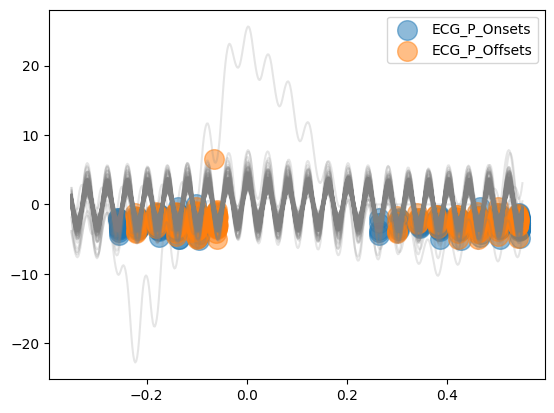

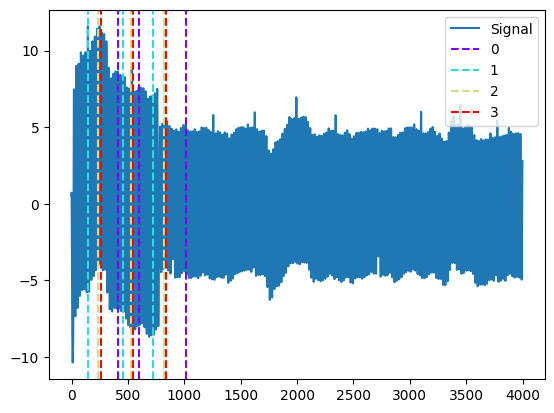

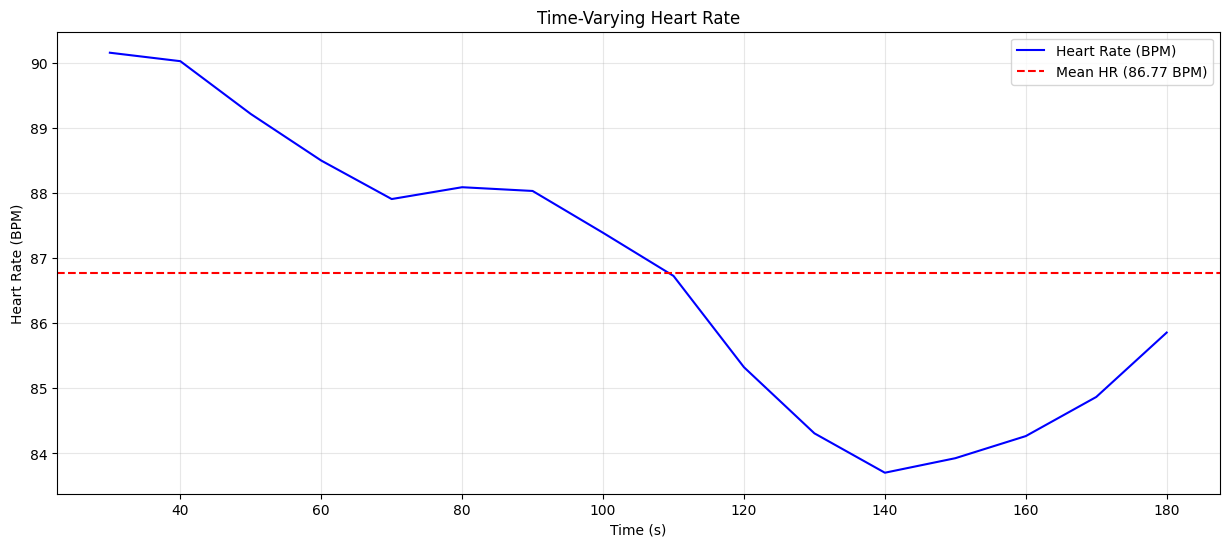

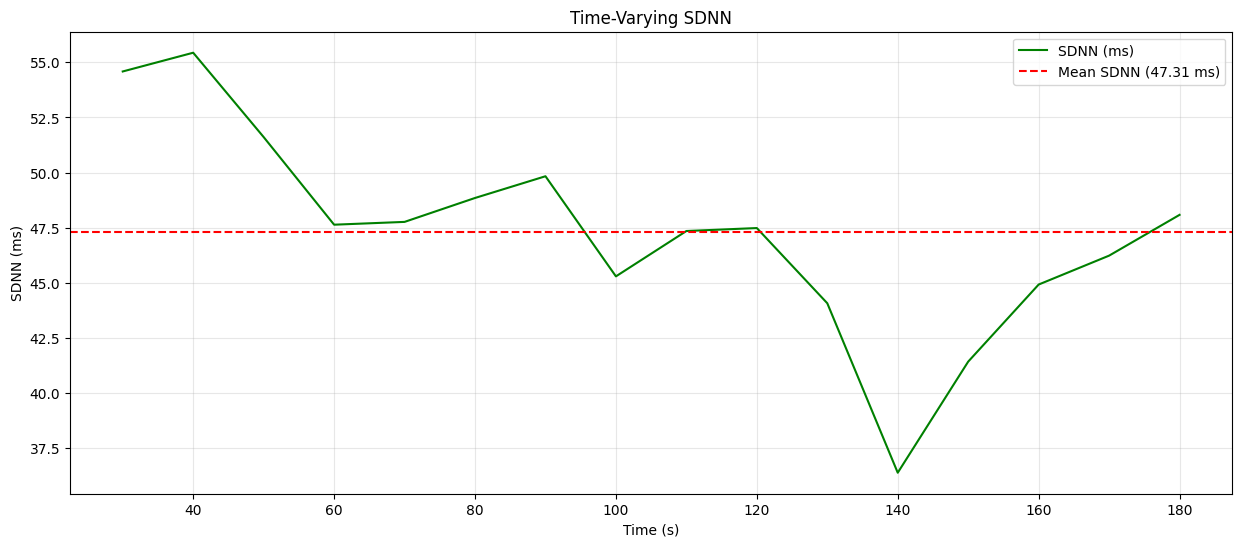

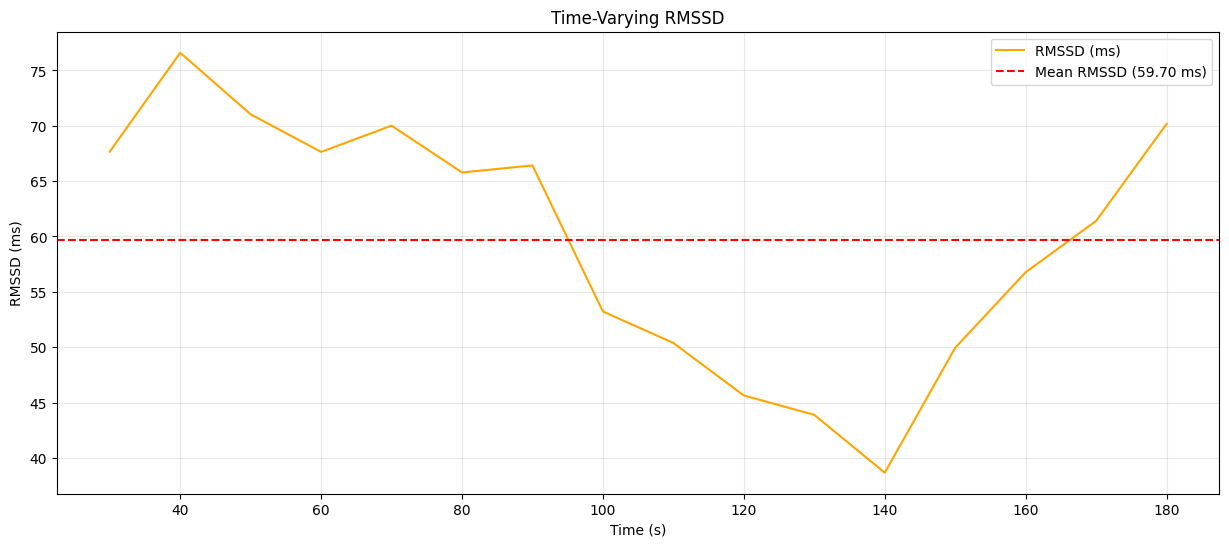

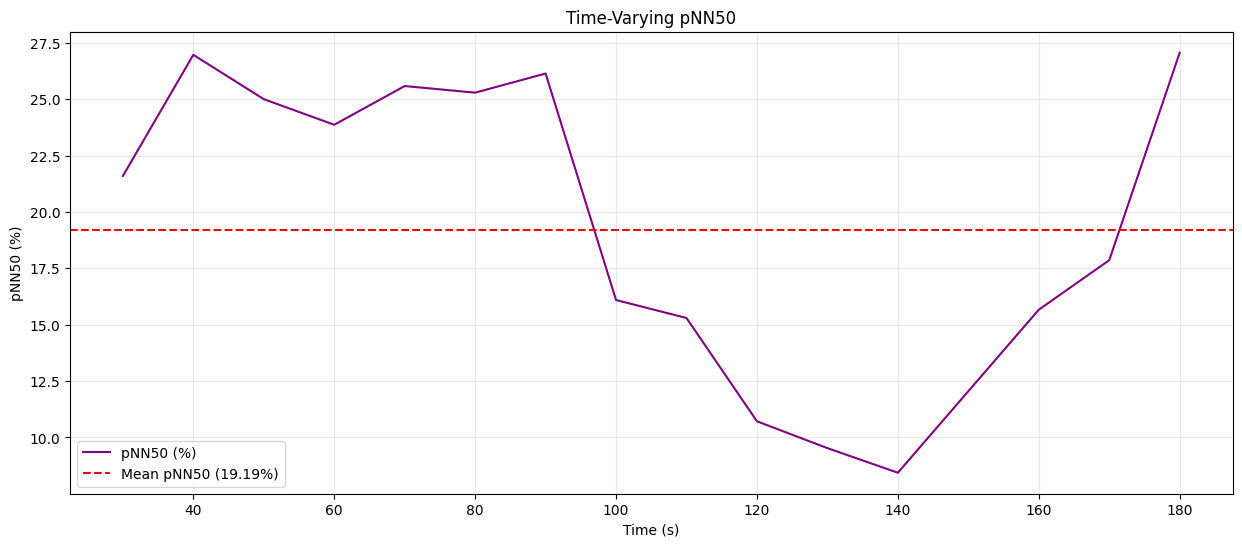

In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from scipy.signal import welch
# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

def detect_rpeaks(ecg_signal, sampling_rate):
    """Enhanced R-peak detection using both NeuroKit2 and find_peaks"""
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
        # Find peaks with optimized parameters
    peaks, _ = find_peaks(ecg_cleaned,
                         distance=int(sampling_rate * 0.5),
                         height=np.mean(ecg_cleaned),
                         prominence=0.3)

    return ecg_cleaned, peaks

def filter_rr_intervals(rr_intervals):
    """Comprehensive RR interval filtering"""
    # Basic physiological limits (40-150 bpm)
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]

    # MAD-based outlier removal (more robust than IQR)
    if len(valid_rr) > 0:
        median_rr = np.median(valid_rr)
        mad = np.median(np.abs(valid_rr - median_rr))
        modified_zscore = 0.6745 * (valid_rr - median_rr) / mad
        valid_rr = valid_rr[np.abs(modified_zscore) < 2.5]

    return valid_rr

def calculate_hrv_metrics(valid_rr, sampling_rate=512):
    """Calculate HRV metrics with strict filtering"""
    if len(valid_rr) < 5:
        return {
            "Mean HR (BPM)": np.nan,
            "Mean RR (ms)": np.nan,
            "RMSSD (ms)": np.nan,
            "SDNN (ms)": np.nan,
            "NN50": np.nan,
            "pNN50 (%)": np.nan,
            "SDSD (ms)": np.nan,
            "SDANN (ms)": np.nan,
            "LF/HF Ratio": np.nan
        }

    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)
    rr_diff = np.diff(valid_rr)
    valid_diffs = rr_diff[np.abs(rr_diff) <= 50]

    if len(valid_diffs) > 0:
        rmssd = np.sqrt(np.mean(valid_diffs ** 2))
        rmssd = min(rmssd, 120)
        nn50 = sum(np.abs(valid_diffs) > 50)
        pnn50 = (nn50 / len(valid_diffs)) * 100
    else:
        rmssd, nn50, pnn50 = np.nan, 0, 0

    sdsd = np.std(valid_diffs) if len(valid_diffs) > 0 else np.nan
    segment_length = 5 * 60 * 1000  # 5 minutes in milliseconds
    num_segments = len(valid_rr) * np.mean(valid_rr) // segment_length
    if num_segments >= 1:
        segments = np.array_split(valid_rr, num_segments)
        sdann = np.mean([np.std(segment) for segment in segments])
    else:
        sdann = np.nan

    if len(valid_rr) > 1:
        time = np.cumsum(valid_rr) / 1000.0
        interpolated_time = np.arange(0, time[-1], 1.0 / sampling_rate)
        interpolated_rr = np.interp(interpolated_time, time, valid_rr)
        detrended_rr = interpolated_rr - np.mean(interpolated_rr)
        freqs, psd = welch(detrended_rr, fs=sampling_rate, nperseg=len(detrended_rr))
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)
        lf_power = np.trapz(psd[(freqs >= lf_band[0]) & (freqs < lf_band[1])],
                            freqs[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
        hf_power = np.trapz(psd[(freqs >= hf_band[0]) & (freqs < hf_band[1])],
                            freqs[(freqs >= hf_band[0]) & (freqs < hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.nan
    else:
        lf_hf_ratio = np.nan

    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50,
        "SDSD (ms)": sdsd,
        "SDANN (ms)": sdann,
        "LF/HF Ratio": lf_hf_ratio
    }

# Updated function for time-varying HRV metrics plotting
# Updated function for time-varying HRV metrics plotting
def plot_time_varying_hrv(rr_intervals, sampling_rate=512):
    """Plot time-varying HRV metrics over time."""
    time = np.cumsum(rr_intervals) / 1000.0  # Convert cumulative RR intervals to seconds
    heart_rate = 60000 / rr_intervals  # Convert RR intervals to heart rate

    # Sliding window parameters
    window_size = 60  # seconds
    step_size = 10  # seconds

    # Initialize time-varying metrics
    time_windows = []
    hr_values = []
    sdnn_values = []
    rmssd_values = []
    pnn50_values = []

    # Sliding window calculation
    for start_time in np.arange(0, time[-1] - window_size, step_size):
        end_time = start_time + window_size
        window_rr = rr_intervals[(time >= start_time) & (time < end_time)]

        if len(window_rr) > 1:
            time_windows.append(start_time + window_size / 2)
            hr_values.append(60000 / np.mean(window_rr))
            sdnn_values.append(np.std(window_rr))
            diffs = np.diff(window_rr)
            rmssd_values.append(np.sqrt(np.mean(diffs ** 2)))
            pnn50_values.append(np.sum(np.abs(diffs) > 50) / len(diffs) * 100)

    # Calculate overall means
    mean_hr = np.mean(hr_values)
    mean_sdnn = np.mean(sdnn_values)
    mean_rmssd = np.mean(rmssd_values)
    mean_pnn50 = np.mean(pnn50_values)

    # Plot Heart Rate
    plt.figure(figsize=(15, 6))
    plt.plot(time_windows, hr_values, label="Heart Rate (BPM)", color='blue')
    plt.axhline(mean_hr, color='red', linestyle='--', label=f'Mean HR ({mean_hr:.2f} BPM)')
    plt.title('Time-Varying Heart Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot SDNN
    plt.figure(figsize=(15, 6))
    plt.plot(time_windows, sdnn_values, label="SDNN (ms)", color='green')
    plt.axhline(mean_sdnn, color='red', linestyle='--', label=f'Mean SDNN ({mean_sdnn:.2f} ms)')
    plt.title('Time-Varying SDNN')
    plt.xlabel('Time (s)')
    plt.ylabel('SDNN (ms)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot RMSSD
    plt.figure(figsize=(15, 6))
    plt.plot(time_windows, rmssd_values, label="RMSSD (ms)", color='orange')
    plt.axhline(mean_rmssd, color='red', linestyle='--', label=f'Mean RMSSD ({mean_rmssd:.2f} ms)')
    plt.title('Time-Varying RMSSD')
    plt.xlabel('Time (s)')
    plt.ylabel('RMSSD (ms)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot pNN50
    plt.figure(figsize=(15, 6))
    plt.plot(time_windows, pnn50_values, label="pNN50 (%)", color='purple')
    plt.axhline(mean_pnn50, color='red', linestyle='--', label=f'Mean pNN50 ({mean_pnn50:.2f}%)')
    plt.title('Time-Varying pNN50')
    plt.xlabel('Time (s)')
    plt.ylabel('pNN50 (%)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
# # Define a new function
# def my_processing(ecg_signal,sampling_rate):
#     # Do processing
#     ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate)
#     instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate)
#     rate = nk.ecg_rate(rpeaks, sampling_rate, desired_length=len(ecg_cleaned))
#     quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)
#     # Prepare output
#     signals = pd.DataFrame({"ECG_Raw": ecg_signal,
#                             "ECG_Clean": ecg_cleaned,
#                             "ECG_Rate": rate,
#                             "ECG_Quality": quality})
#     signals = pd.concat([signals, instant_peaks], axis=1)

#     # Create info dict
#     info = rpeaks
#     info["sampling_rate"] = sampling_rate
#     return signals, info
try:
    # Load and prepare ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values/1000   # Convert to V
    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")
    # Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(ecg_signal, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")
    # Visualize P-wave boundaries
    rate = nk.ecg_rate(peaks, sampling_rate, desired_length=len(ecg_cleaned))
    print(rate)
    signal_dwt, waves_dwt = nk.ecg_delineate(ecg_cleaned,
                                         peaks,
                                         sampling_rate=512,
                                         method="dwt",
                                         show=True,
                                         show_type='bounds_P')
    _, waves_peak = nk.ecg_delineate(ecg_signal, peaks, sampling_rate, method="peak")
    # Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
    plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_signal[:4000])
    if len(peaks) >= 5:
        # Calculate and filter RR intervals
        rr_intervals = np.diff(peaks) / sampling_rate * 1000
        valid_rr = filter_rr_intervals(rr_intervals)

        if len(valid_rr) >= 5:
            # Calculate HRV metrics
            hr_metrics = calculate_hrv_metrics(valid_rr)
            hr_metrics["Number of Valid R-Peaks"] = len(peaks)

            # Save results
            pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
            pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

            # Display results
            print("\nHR Metrics:")
            for metric, value in hr_metrics.items():
                print(f"{metric}: {value}")

            plot_time_varying_hrv( valid_rr,sampling_rate)

            # # Plot ECG with R-peaks
            # plt.figure(figsize=(15, 4))
            # plt.plot(ecg_cleaned, label='Cleaned ECG', alpha=0.7)
            # plt.scatter(peaks, ecg_cleaned[peaks], color='red', label='R-peaks', zorder=3)
            # plt.title('ECG Signal with Detected R-peaks')
            # plt.xlabel('Samples')
            # plt.ylabel('Amplitude (µV)')
            # plt.legend()
            # plt.grid(True, alpha=0.3)
            # plt.show()

            # # Plot heart rate over samples
            # heart_rate = 60000 / valid_rr  # Convert RR intervals to HR
            # mean_rr = np.mean(valid_rr)
            # mean_hr = 60000 / mean_rr
            # plt.figure(figsize=(15, 6))
            # plt.plot(heart_rate, label='Heart Rate (BPM)', color='blue', alpha=0.7)
            # plt.title('Heart Rate Over Samples')
            # plt.xlabel('Beat Number')
            # plt.ylabel('Heart Rate (BPM)')
            # plt.axhline(mean_hr, color='red', linestyle='--', label='Mean Heart Rate')
            # plt.legend()
            # plt.grid(alpha=0.3)
            # plt.show()

            # # Plot RR intervals
            # plt.figure(figsize=(15, 4))
            # plt.plot(valid_rr, 'b-', label='RR Intervals', alpha=0.7)
            # plt.axhline(y=np.mean(valid_rr), color='r', linestyle='--', label='Mean RR')
            # plt.title('RR Intervals Time Series')
            # plt.xlabel('Beat Number')
            # plt.ylabel('RR Interval (ms)')
            # plt.legend()
            # plt.grid(True, alpha=0.3)
            # plt.show()

        else:
            print("Insufficient valid RR intervals after filtering.")
    else:
        print("Insufficient R-peaks detected for analysis.")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug Information:")
    print(f"ECG Signal Shape: {ecg_signal.shape}")
    print(f"ECG Signal Range: [{np.min(ecg_signal)}, {np.max(ecg_signal)}]")

Using Fixed Sampling Rate: 512 Hz


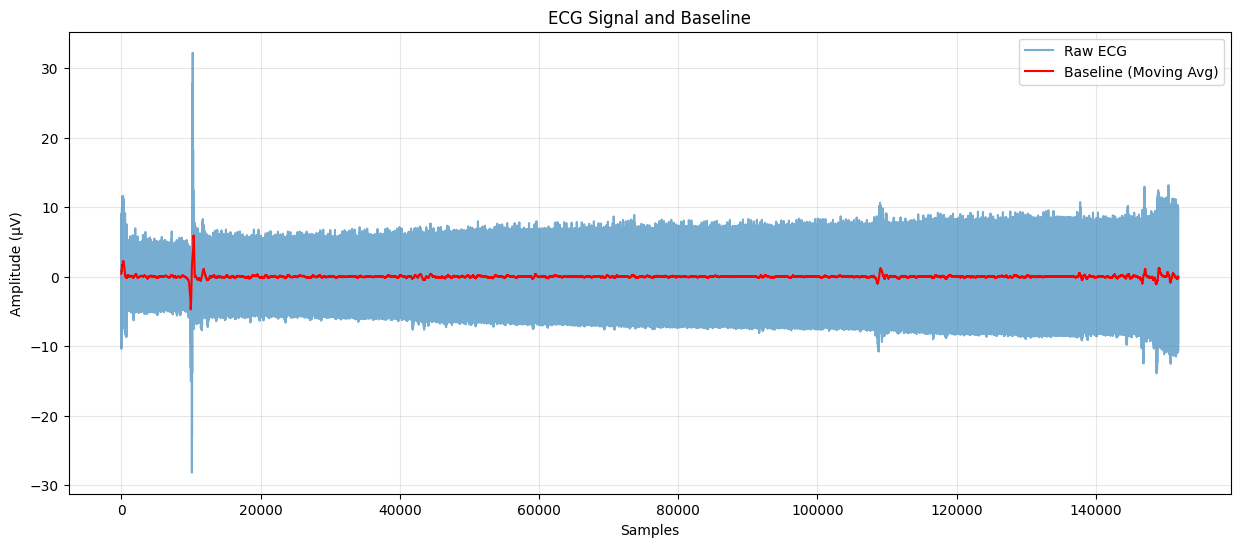

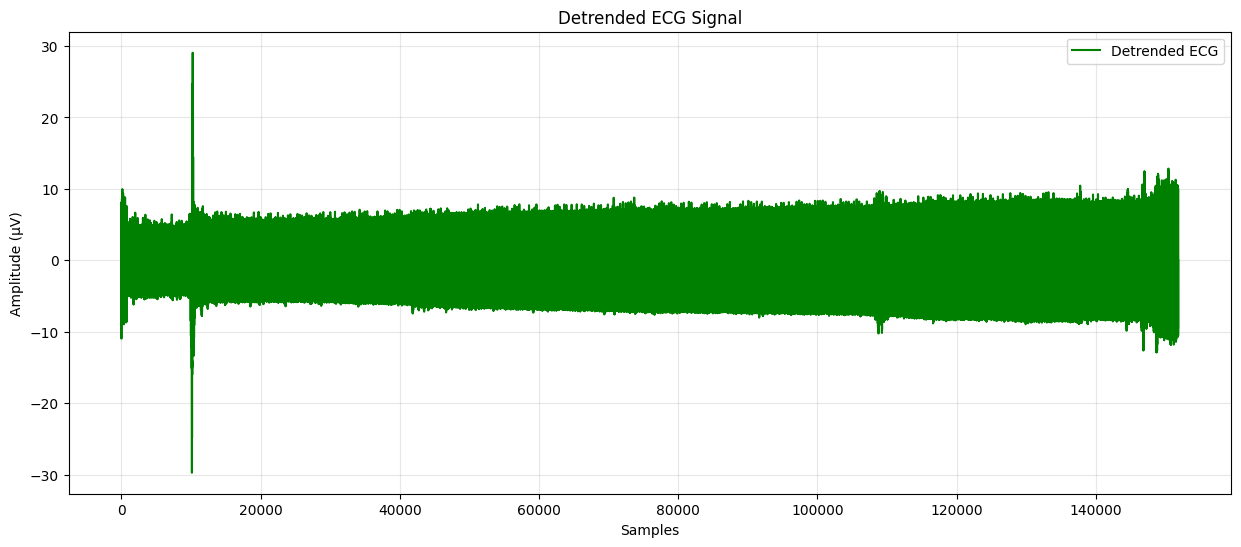

Baseline Standard Deviation: 0.30 µV
Significant baseline variation detected.
Number of R-peaks detected: 433

HR Metrics:
Mean HR (BPM): 87.57410071942446
Mean RR (ms): 685.1340694006309
RMSSD (ms): 66.86450037794995
SDNN (ms): 54.94728924512953
NN50: 75
pNN50 (%): 23.734177215189874
SDSD (ms): 66.8645000922828
Number of Valid R-Peaks: 433


In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import welch

# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")

def detect_rpeaks(ecg_signal, sampling_rate):
    """Enhanced R-peak detection using both NeuroKit2 and find_peaks."""
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
    # Find peaks with optimized parameters
    peaks, _ = find_peaks(ecg_cleaned,
                          distance=int(sampling_rate * 0.5),
                          height=np.mean(ecg_cleaned),
                          prominence=0.3)
    return ecg_cleaned, peaks

def check_baseline_variation(ecg_signal, sampling_rate):
    """Check for baseline variation in the ECG signal."""
    # Calculate moving average for baseline estimation
    window_size = int(sampling_rate * 0.8)  # 0.8 seconds moving average
    baseline = np.convolve(ecg_signal, np.ones(window_size) / window_size, mode='same')

    # Subtract baseline and check for residual baseline drift
    detrended_signal = ecg_signal - baseline
    baseline_std = np.std(baseline)

    # Plot baseline and detrended ECG
    plt.figure(figsize=(15, 6))
    plt.plot(ecg_signal, label="Raw ECG", alpha=0.6)
    plt.plot(baseline, label="Baseline (Moving Avg)", color='red')
    plt.title('ECG Signal and Baseline')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(detrended_signal, label="Detrended ECG", color='green')
    plt.title('Detrended ECG Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Baseline Standard Deviation: {baseline_std:.2f} µV")
    return baseline_std


def filter_rr_intervals(rr_intervals):
    """Comprehensive RR interval filtering."""
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]
    if len(valid_rr) > 0:
        median_rr = np.median(valid_rr)
        mad = np.median(np.abs(valid_rr - median_rr))
        modified_zscore = 0.6745 * (valid_rr - median_rr) / mad
        valid_rr = valid_rr[np.abs(modified_zscore) < 2.5]
    return valid_rr

def calculate_hrv_metrics(valid_rr, sampling_rate=512):
    """Calculate HRV metrics."""
    if len(valid_rr) < 5:
        return {
            "Mean HR (BPM)": np.nan,
            "Mean RR (ms)": np.nan,
            "RMSSD (ms)": np.nan,
            "SDNN (ms)": np.nan,
            "NN50": np.nan,
            "pNN50 (%)": np.nan,
            "SDSD (ms)": np.nan,
            "SDANN (ms)": np.nan,
            "LF/HF Ratio": np.nan
        }
    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)
    rr_diff = np.diff(valid_rr)
    rmssd = np.sqrt(np.mean(rr_diff ** 2)) if len(rr_diff) > 0 else np.nan
    nn50 = sum(np.abs(rr_diff) > 50)
    pnn50 = (nn50 / len(rr_diff)) * 100 if len(rr_diff) > 0 else 0
    sdsd = np.std(rr_diff)
    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50,
        "SDSD (ms)": sdsd
    }

try:
    # Load and prepare ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values / 1000   # Convert to V
    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")

    # Check for baseline variation
    baseline_std = check_baseline_variation(ecg_signal, sampling_rate)
    if baseline_std > 0.1:
        print("Significant baseline variation detected.")
    else:
        print("No significant baseline variation detected.")

    # Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(ecg_signal, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")

    if len(peaks) >= 5:
        # Calculate and filter RR intervals
        rr_intervals = np.diff(peaks) / sampling_rate * 1000
        valid_rr = filter_rr_intervals(rr_intervals)
        if len(valid_rr) >= 5:
            # Calculate HRV metrics
            hr_metrics = calculate_hrv_metrics(valid_rr)
            hr_metrics["Number of Valid R-Peaks"] = len(peaks)
            print("\nHR Metrics:")
            for metric, value in hr_metrics.items():
                print(f"{metric}: {value}")
        else:
            print("Insufficient valid RR intervals after filtering.")
    else:
        print("Insufficient R-peaks detected for analysis.")

except Exception as e:
    print(f"Error occurred: {str(e)}")


Using Fixed Sampling Rate: 512 Hz


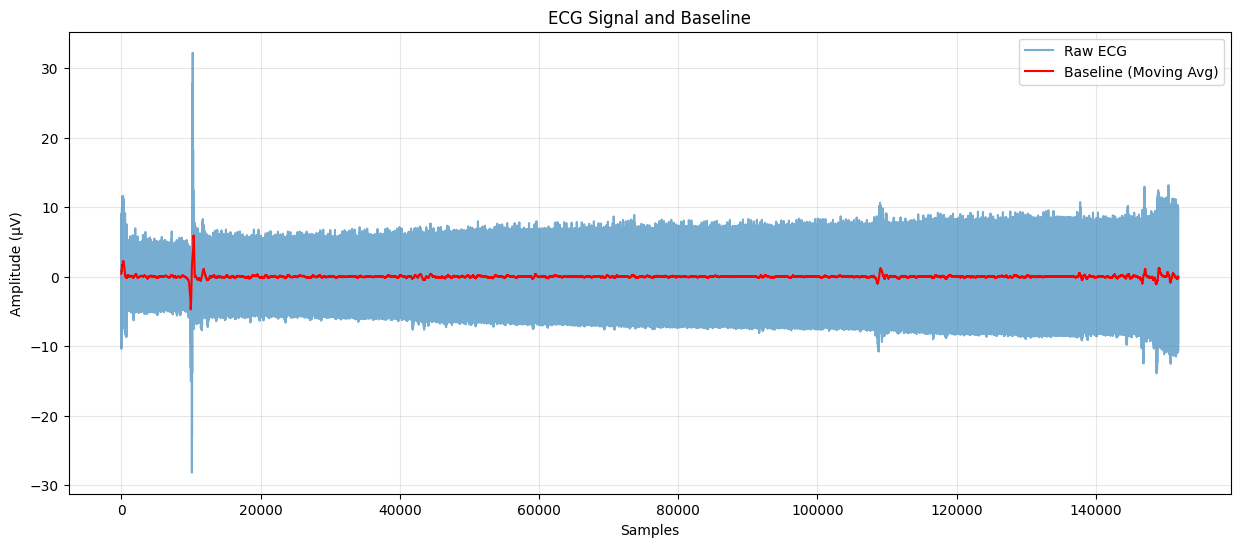

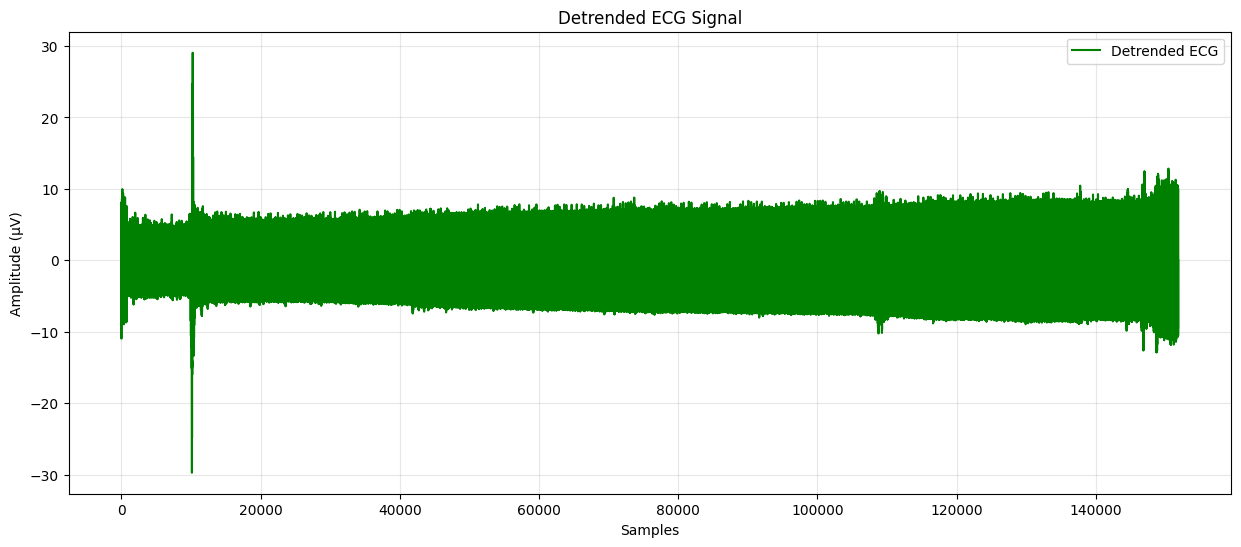

Baseline Standard Deviation: 0.30 µV
Significant baseline variation detected. Applying baseline correction.
Number of R-peaks detected: 433

HR Metrics:
Mean HR (BPM): 87.60687597370018
Mean RR (ms): 684.8777488425926
RMSSD (ms): 155.68703755835114
SDNN (ms): 107.2451302836541
NN50: 205
pNN50 (%): 47.56380510440835
LF/HF Ratio: nan
Number of Valid R-Peaks: 433


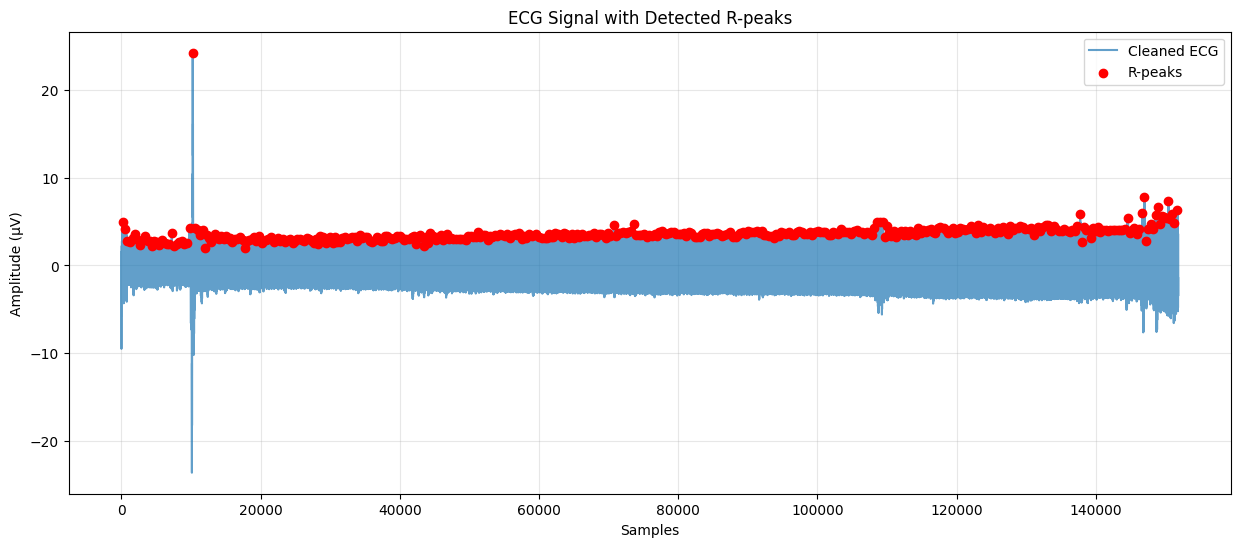

In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")


def detect_rpeaks(ecg_signal, sampling_rate):
    """Enhanced R-peak detection using both NeuroKit2 and find_peaks"""
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
    # Find peaks with optimized parameters
    peaks, _ = find_peaks(ecg_cleaned,
                          distance=int(sampling_rate * 0.5),
                          height=np.mean(ecg_cleaned),
                          prominence=0.3)
    return ecg_cleaned, peaks


def filter_rr_intervals(rr_intervals):
    """Comprehensive RR interval filtering"""
    # Basic physiological limits (40-150 bpm)
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]
    return valid_rr


def calculate_hrv_metrics(valid_rr):
    """Calculate HRV metrics with strict filtering"""
    if len(valid_rr) < 5:
        return {
            "Mean HR (BPM)": np.nan,
            "Mean RR (ms)": np.nan,
            "RMSSD (ms)": np.nan,
            "SDNN (ms)": np.nan,
            "NN50": np.nan,
            "pNN50 (%)": np.nan,
            "LF/HF Ratio": np.nan,
        }
    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)
    rr_diff = np.diff(valid_rr)
    rmssd = np.sqrt(np.mean(rr_diff ** 2))
    nn50 = sum(np.abs(rr_diff) > 50)
    pnn50 = (nn50 / len(rr_diff)) * 100 if len(rr_diff) > 0 else 0
    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50,
        "LF/HF Ratio": np.nan,  # Placeholder
    }


def check_baseline_variation(ecg_signal, sampling_rate):
    """Check for baseline variation in the ECG signal."""
    # Calculate moving average for baseline estimation
    window_size = int(sampling_rate * 0.8)  # 0.8 seconds moving average
    baseline = np.convolve(ecg_signal, np.ones(window_size) / window_size, mode='same')

    # Subtract baseline and check for residual baseline drift
    detrended_signal = ecg_signal - baseline
    baseline_std = np.std(baseline)

    # Plot baseline and detrended ECG
    plt.figure(figsize=(15, 6))
    plt.plot(ecg_signal, label="Raw ECG", alpha=0.6)
    plt.plot(baseline, label="Baseline (Moving Avg)", color='red')
    plt.title('ECG Signal and Baseline')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(detrended_signal, label="Detrended ECG", color='green')
    plt.title('Detrended ECG Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Baseline Standard Deviation: {baseline_std:.2f} µV")
    return detrended_signal, baseline_std


try:
    # Load and prepare ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values / 1000  # Convert to V
    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")

    # Check and correct baseline variation
    detrended_signal, baseline_std = check_baseline_variation(ecg_signal, sampling_rate)

    # Apply baseline correction if significant variation is detected
    if baseline_std > 0.05:  # Threshold for baseline standard deviation
        print("Significant baseline variation detected. Applying baseline correction.")
        ecg_signal = detrended_signal
    else:
        print("No significant baseline variation detected.")

    # Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(ecg_signal, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")

    # Calculate and filter RR intervals
    rr_intervals = np.diff(peaks) / sampling_rate * 1000
    valid_rr = filter_rr_intervals(rr_intervals)

    if len(valid_rr) >= 5:
        # Calculate HRV metrics
        hr_metrics = calculate_hrv_metrics(valid_rr)
        hr_metrics["Number of Valid R-Peaks"] = len(peaks)

        # Save results
        pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
        pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

        # Display results
        print("\nHR Metrics:")
        for metric, value in hr_metrics.items():
            print(f"{metric}: {value}")

        # Plot ECG with R-peaks
        plt.figure(figsize=(15, 6))
        plt.plot(ecg_cleaned, label='Cleaned ECG', alpha=0.7)
        plt.scatter(peaks, ecg_cleaned[peaks], color='red', label='R-peaks', zorder=3)
        plt.title('ECG Signal with Detected R-peaks')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude (µV)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Insufficient valid RR intervals after filtering.")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug Information:")
    print(f"ECG Signal Range: [{np.min(ecg_signal)}, {np.max(ecg_signal)}]")


Using Fixed Sampling Rate: 512 Hz
Baseline correction using ModPoly applied.
Number of R-peaks detected: 429
Number of valid RR intervals: 428

HR Metrics:
Mean HR (BPM): 85.96
Mean RR (ms): 698.03
RMSSD (ms): 30.52
SDNN (ms): 141.95
NN50: 280.00
pNN50 (%): 65.57
LF/HF Ratio: 0.52
Number of Valid R-Peaks: 429.00


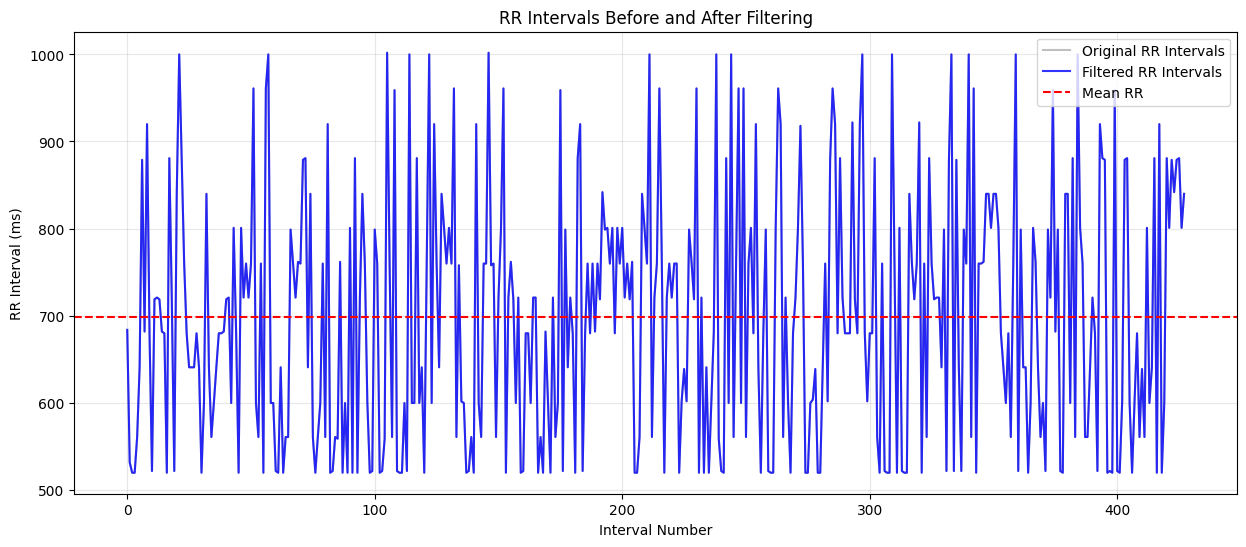

In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.signal import welch

# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")


def modpoly_baseline_correction(signal, degree=5):
    """Apply ModPoly baseline correction to eliminate the DC component."""
    x = np.arange(len(signal)).reshape(-1, 1)
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, signal)
    baseline = model.predict(x_poly)
    corrected_signal = signal - baseline
    return corrected_signal, baseline

def detect_rpeaks(ecg_signal, sampling_rate):
    """Enhanced R-peak detection using both NeuroKit2 and find_peaks."""
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')

    # Detect R-peaks
    peaks, _ = find_peaks(ecg_cleaned,
                          distance=int(sampling_rate * 0.5),
                          prominence=0.3,
                          height=np.mean(ecg_cleaned))
    return ecg_cleaned, peaks

def filter_rr_intervals_enhanced(rr_intervals):
    """
    Enhanced RR interval filtering:
    - Removes intervals outside physiological ranges.
    - Applies robust outlier removal based on median and MAD.
    """
    # Physiological limits (400–1500 ms)
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]

    if len(valid_rr) > 0:
        # Compute median and MAD
        median_rr = np.median(valid_rr)
        mad = np.median(np.abs(valid_rr - median_rr))
        threshold = 3.0 * mad  # Adjust threshold dynamically
        valid_rr = valid_rr[np.abs(valid_rr - median_rr) <= threshold]

    return valid_rr

def calculate_hrv_metrics_improved(valid_rr, sampling_rate=512):
    """
    Calculate HRV metrics, including LF/HF ratio, with enhanced filtering.
    """
    if len(valid_rr) < 5:
        return {
            "Mean HR (BPM)": np.nan,
            "Mean RR (ms)": np.nan,
            "RMSSD (ms)": np.nan,
            "SDNN (ms)": np.nan,
            "NN50": np.nan,
            "pNN50 (%)": np.nan,
            "LF/HF Ratio": np.nan
        }

    # Basic HRV metrics
    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)

    # RMSSD computation
    rr_diff = np.diff(valid_rr)
    valid_diffs = rr_diff[np.abs(rr_diff) <= 50]  # Remove unreasonably large differences
    rmssd = np.sqrt(np.mean(valid_diffs ** 2))

    # NN50 and pNN50
    nn50 = sum(np.abs(rr_diff) > 50)
    pnn50 = (nn50 / len(rr_diff)) * 100

    # Frequency-domain analysis for LF/HF Ratio
    if len(valid_rr) > 1:
        # Resample RR intervals for uniform time steps
        time = np.cumsum(valid_rr) / 1000.0  # Convert cumulative RR intervals to seconds
        interpolated_time = np.arange(0, time[-1], 1.0 / sampling_rate)
        interpolated_rr = np.interp(interpolated_time, time, valid_rr)

        # Detrend the signal
        detrended_rr = interpolated_rr - np.mean(interpolated_rr)

        # Perform Welch PSD
        freqs, psd = welch(detrended_rr, fs=sampling_rate, nperseg=len(detrended_rr))

        # LF and HF power bands
        lf_band = (0.04, 0.15)  # Low frequency band
        hf_band = (0.15, 0.4)   # High frequency band

        # Calculate LF and HF power
        lf_power = np.trapz(psd[(freqs >= lf_band[0]) & (freqs < lf_band[1])],
                            freqs[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
        hf_power = np.trapz(psd[(freqs >= hf_band[0]) & (freqs < hf_band[1])],
                            freqs[(freqs >= hf_band[0]) & (freqs < hf_band[1])])

        # Calculate LF/HF Ratio
        lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.nan
    else:
        lf_hf_ratio = np.nan

    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50,
        "LF/HF Ratio": lf_hf_ratio
    }

try:
    # Load ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values / 1000  # Convert to volts
    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")

    # Apply ModPoly baseline correction
    ecg_corrected, baseline = modpoly_baseline_correction(ecg_signal)
    print("Baseline correction using ModPoly applied.")

    # Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(ecg_corrected, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")

    # Calculate and filter RR intervals
    rr_intervals = np.diff(peaks) / sampling_rate * 1000  # Convert to ms
    valid_rr = filter_rr_intervals_enhanced(rr_intervals)
    print(f"Number of valid RR intervals: {len(valid_rr)}")

    if len(valid_rr) >= 5:
        # Calculate HRV metrics
        hr_metrics = calculate_hrv_metrics_improved(valid_rr)
        hr_metrics["Number of Valid R-Peaks"] = len(peaks)

        # Save results
        pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
        pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

        # Display results
        print("\nHR Metrics:")
        for metric, value in hr_metrics.items():
            print(f"{metric}: {value:.2f}")

        # Plot RR intervals to verify filtering
        plt.figure(figsize=(15, 6))
        plt.plot(rr_intervals, label="Original RR Intervals", alpha=0.5, color='gray')
        plt.plot(valid_rr, label="Filtered RR Intervals", alpha=0.8, color='blue')
        plt.axhline(y=np.mean(valid_rr), color='red', linestyle='--', label='Mean RR')
        plt.title('RR Intervals Before and After Filtering')
        plt.xlabel('Interval Number')
        plt.ylabel('RR Interval (ms)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Insufficient valid RR intervals for HRV calculation.")

except Exception as e:
    print(f"Error occurred: {str(e)}")

ECG filtering using NeuroKit2 completed.
ModPoly baseline correction applied.
Using Fixed Sampling Rate: 512 Hz
Number of R-peaks detected: 431

HR Metrics:
Mean HR (BPM): 87.61984509106134
Mean RR (ms): 684.776376146789
RMSSD (ms): 28.195659517580015
SDNN (ms): 53.47501923003102
NN50: 78
pNN50 (%): 23.92638036809816
LF/HF Ratio: 0.8220742539705007
Number of Valid R-Peaks: 431


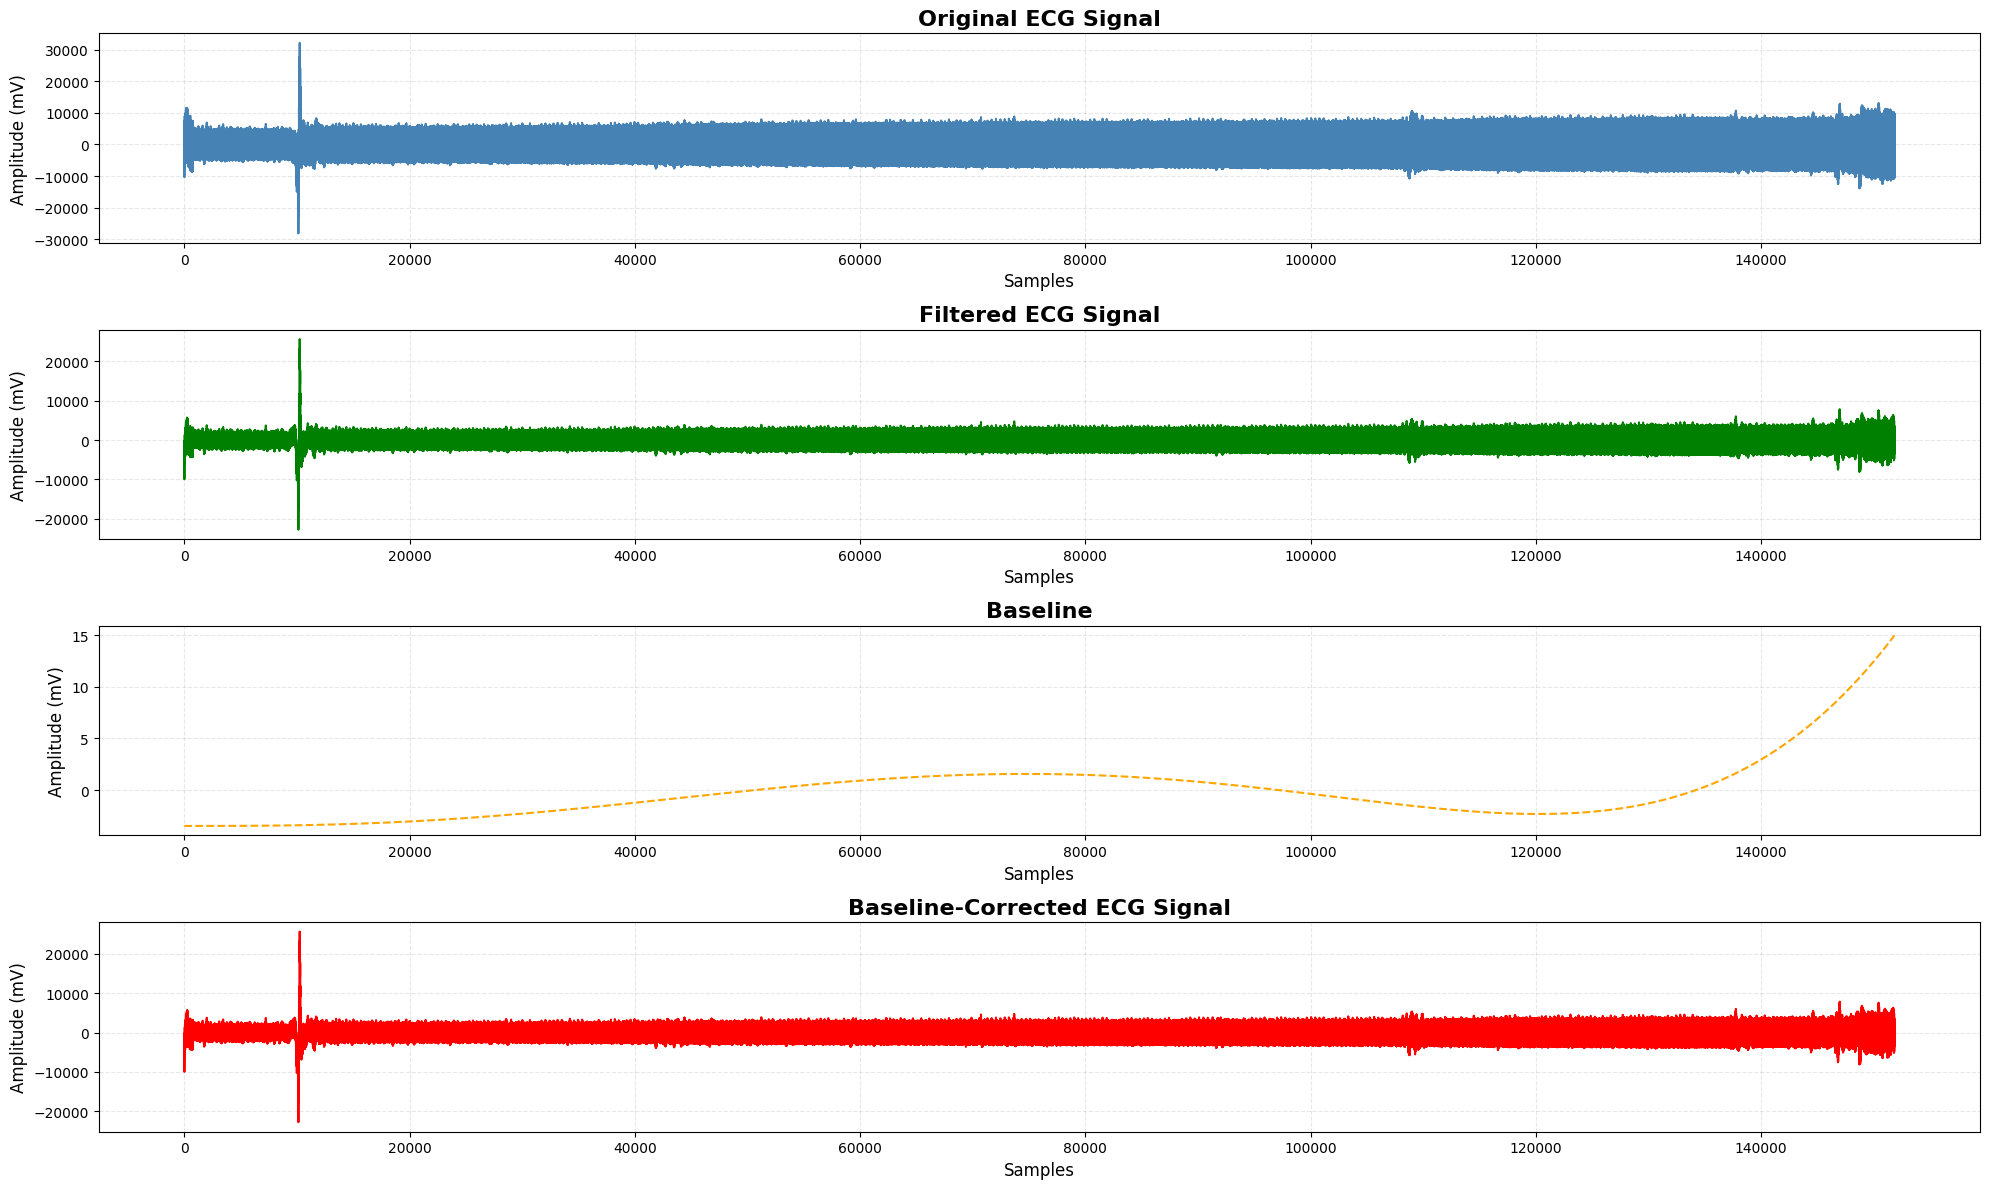

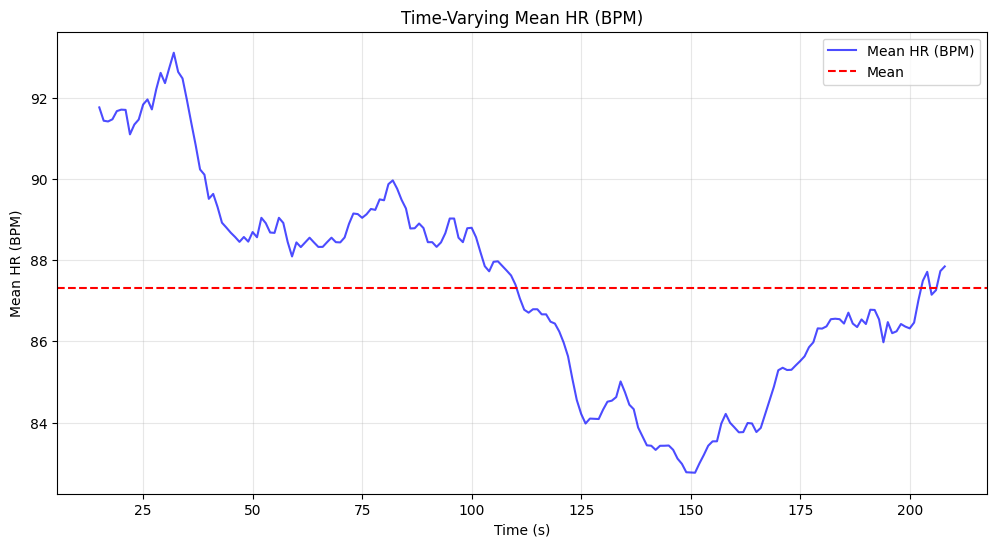

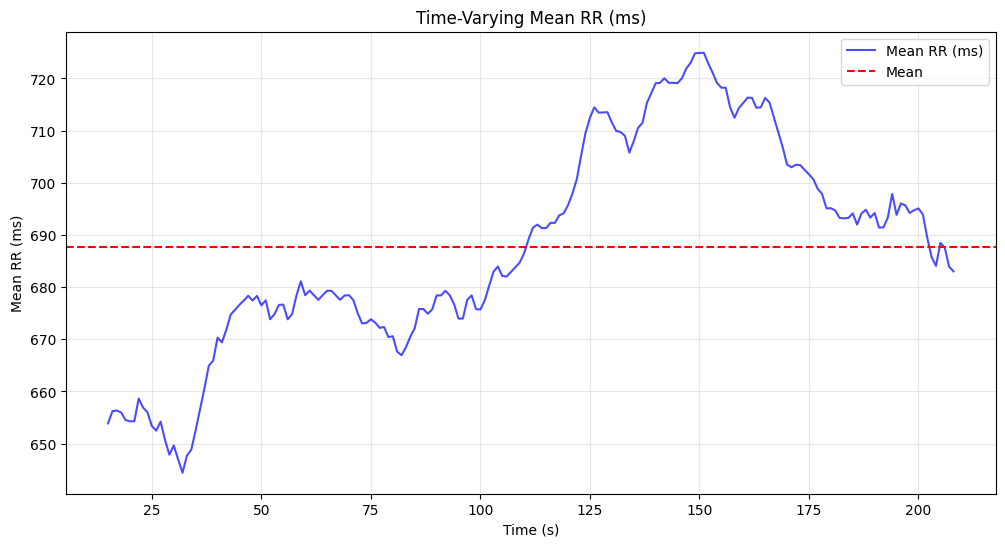

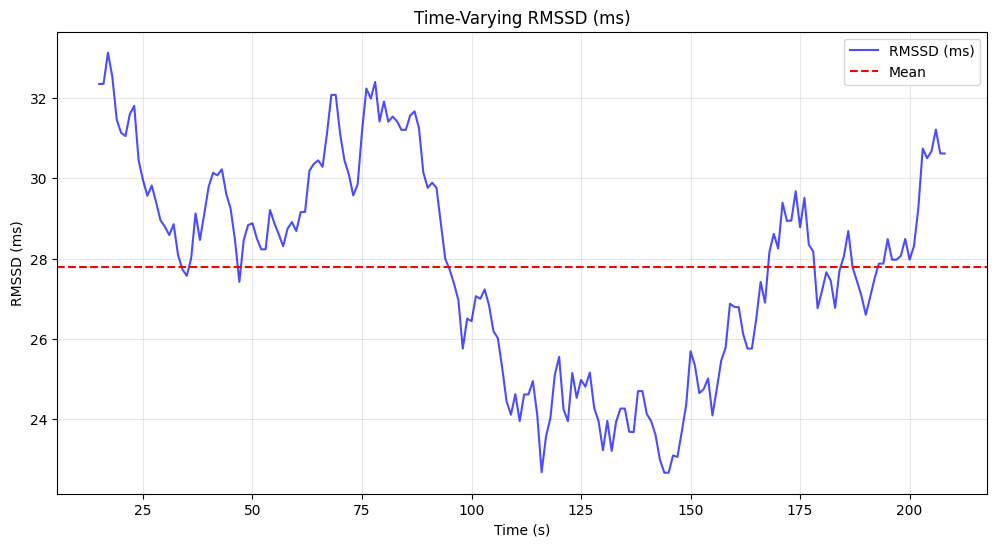

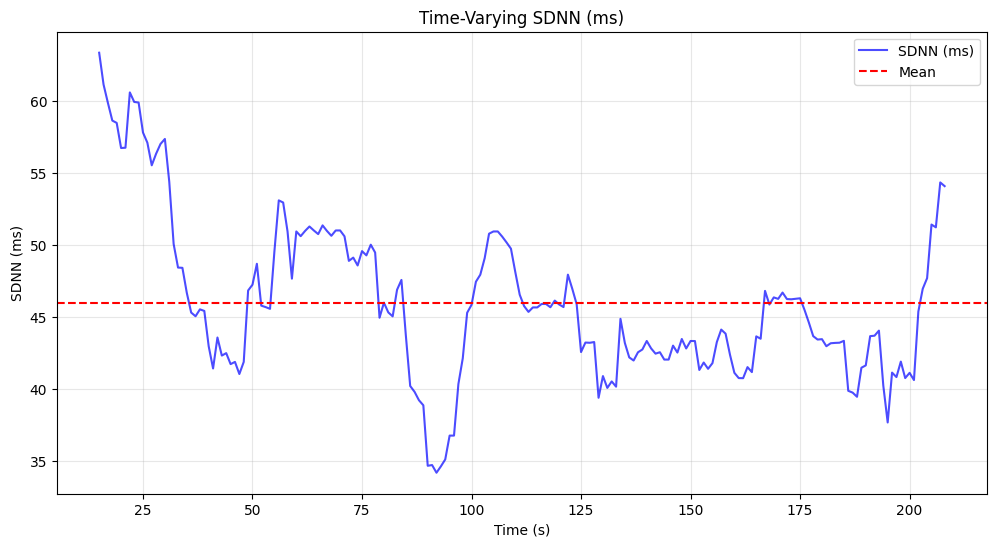

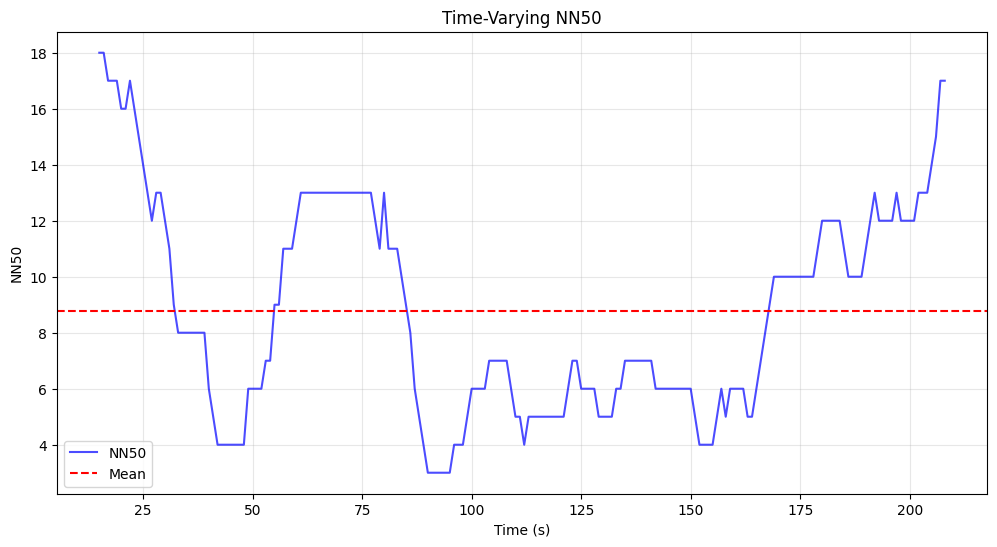

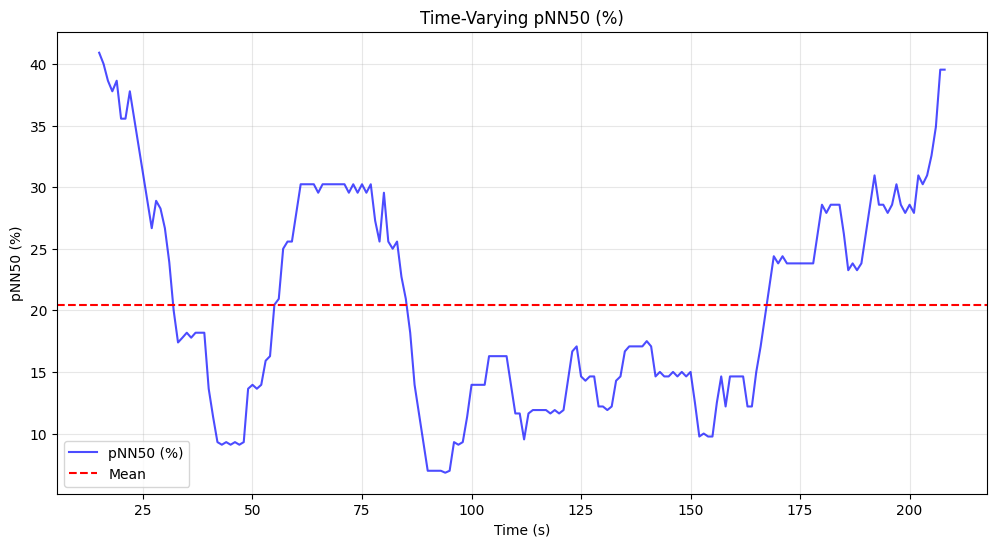

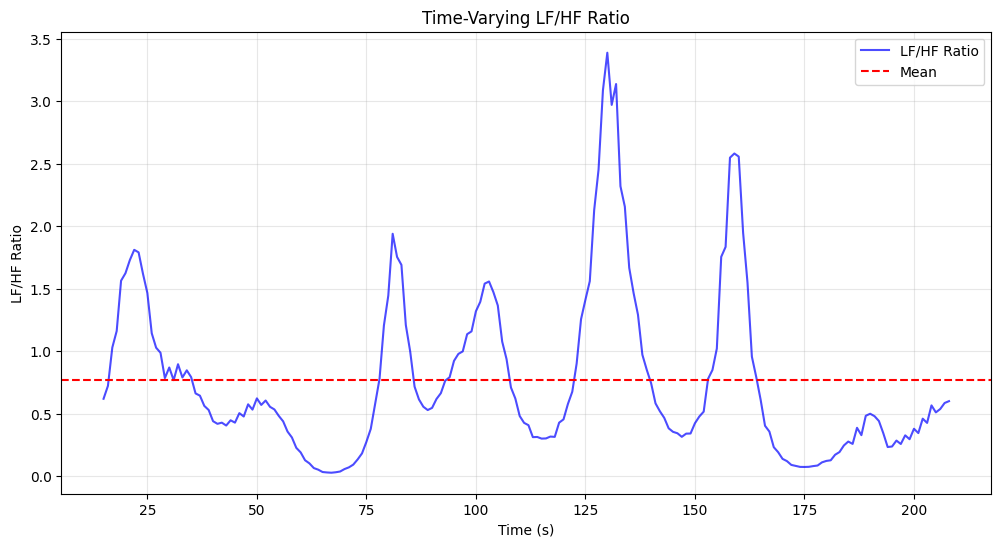

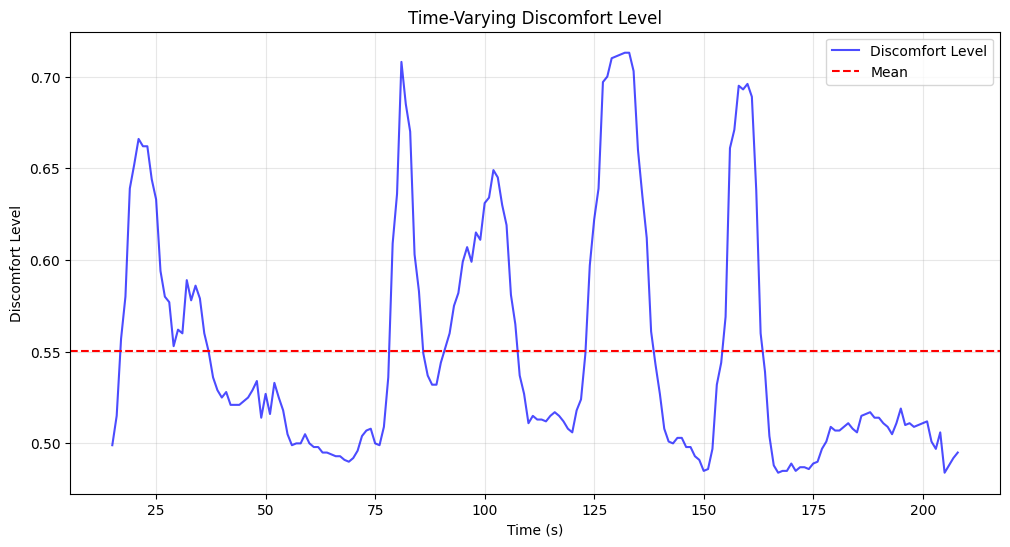

In [5]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import os
# File paths setup
flpath = '/content/drive/My Drive/BTECH_ECG_PROJECT/Sample_Data/'
input_file = os.path.join(flpath, "ECG_Ref1.csv")
rr_intervals_output = os.path.join(flpath, "rr_intervals.csv")
hr_metrics_output = os.path.join(flpath, "hr_metrics.csv")
time_varying_hrv_output= os.path.join(flpath, "time_varying_hrv.csv")

def modpoly_baseline_correction(signal, degree=5):
    """Apply ModPoly baseline correction to eliminate the DC component."""
    x = np.arange(len(signal)).reshape(-1, 1)
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, signal)
    baseline = model.predict(x_poly)
    corrected_signal = signal - baseline
    return corrected_signal, baseline

def calculate_discomfort_level_for_matrices(hrv_matrices):
    """
    Calculate discomfort levels for given HRV matrices and save to the output file.

    Parameters:
    hrv_matrices: pandas.DataFrame
        DataFrame containing time-varying HRV metrics with columns:
        ['Mean HR (BPM)', 'Mean RR (ms)', 'RMSSD (ms)', 'SDNN (ms)', 'NN50', 'pNN50 (%)', 'LF/HF Ratio'].
    output_file: str
        Path to save the updated HRV matrices with discomfort levels.

    Returns:
    None
    """
    def fuzzy_discomfort_logic(row):
        """
        Calculate discomfort level using fuzzy logic based on HRV metrics.
        """
        # Example fuzzy rules for discomfort level calculation
        hr_discomfort = max(0, min(1, (row['Mean HR (BPM)'] - 60) / 40))  # Normalize HR to 0-1 scale
        rmssd_discomfort = max(0, min(1, 1 - (row['RMSSD (ms)'] / 100)))  # Lower RMSSD = more discomfort
        sdnn_discomfort = max(0, min(1, 1 - (row['SDNN (ms)'] / 80)))  # Lower SDNN = more discomfort
        lf_hf_discomfort = max(0, min(1, (row['LF/HF Ratio'] - 0.5) / 1.5))  # Normalize LF/HF Ratio

        # Weighted aggregation of discomfort levels (weights can be adjusted)
        return 0.3 * hr_discomfort + 0.3 * rmssd_discomfort + 0.2 * sdnn_discomfort + 0.2 * lf_hf_discomfort

    # Apply the fuzzy discomfort logic to each row in the DataFrame
    hrv_matrices['Discomfort Level'] = hrv_matrices.apply(fuzzy_discomfort_logic, axis=1).round(3)
    return hrv_matrices


def detect_rpeaks(ecg_signal, sampling_rate):
    """
    Enhanced R-peak detection using both NeuroKit2 and find_peaks
    """
    # Clean ECG using NeuroKit2
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate, method='neurokit')
    # Find peaks with optimized parameters
    peaks, _ = find_peaks(ecg_cleaned,
                         distance=int(sampling_rate * 0.5),
                         height=np.mean(ecg_cleaned),
                         prominence=0.3)
    return ecg_cleaned, peaks

def plot_time_varying_hrv(rr_intervals, sampling_rate=512):
    """Generate time-varying HRV plots and save metrics."""
    time = np.cumsum(rr_intervals) / 1000.0
    window_size = 30  # seconds
    step_size = 1  # seconds
    time_windows, hrv_metrics = [], []

    for start_time in np.arange(0, time[-1] - window_size, step_size):
        end_time = start_time + window_size
        window_rr = rr_intervals[(time >= start_time) & (time < end_time)]
        if len(window_rr) > 5:
            time_windows.append(start_time + window_size / 2)
            hrv_metrics.append(calculate_hrv_metrics(window_rr, sampling_rate))

    df_hrv_metrics = pd.DataFrame(hrv_metrics)
    df_hrv_metrics['Time (s)'] = time_windows
    df_time_metrics_cf_level=calculate_discomfort_level_for_matrices(df_hrv_metrics)
    df_time_metrics_cf_level.sort_values(by='Time (s)', inplace=True)
    df_time_metrics_cf_level.reset_index(drop=True, inplace=True)
    df_time_metrics_cf_level.to_csv(time_varying_hrv_output, index=False)

    for metric in ["Mean HR (BPM)", "Mean RR (ms)", "RMSSD (ms)", "SDNN (ms)", "NN50", "pNN50 (%)", "LF/HF Ratio","Discomfort Level"]:
        plt.figure(figsize=(12, 6))
        plt.plot(df_hrv_metrics['Time (s)'], df_time_metrics_cf_level[metric], label=metric, color='blue', alpha=0.7)
        plt.title(f"Time-Varying {metric}")
        plt.xlabel("Time (s)")
        plt.ylabel(metric)
        plt.axhline(y=np.nanmean(df_time_metrics_cf_level[metric]), color='red', linestyle='--', label='Mean')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

def filter_rr_intervals(rr_intervals):
    """
    Comprehensive RR interval filtering
    """
    # Basic physiological limits (40-150 bpm)
    valid_rr = rr_intervals[(rr_intervals >= 400) & (rr_intervals <= 1500)]
    # MAD-based outlier removal (more robust than IQR)
    if len(valid_rr) > 0:
        median_rr = np.median(valid_rr)
        mad = np.median(np.abs(valid_rr - median_rr))
        modified_zscore = 0.6745 * (valid_rr - median_rr) / mad
        valid_rr = valid_rr[np.abs(modified_zscore) < 2.5]
    return valid_rr

def calculate_hrv_metrics(valid_rr, sampling_rate=512):
    """
    Calculate HRV metrics with strict filtering
    """
    if len(valid_rr) < 5:
        return {
            "Mean HR (BPM)": np.nan,
            "Mean RR (ms)": np.nan,
            "RMSSD (ms)": np.nan,
            "SDNN (ms)": np.nan,
            "NN50": np.nan,
            "pNN50 (%)": np.nan,
            "LF/HF Ratio": np.nan
        }

    mean_rr = np.mean(valid_rr)
    mean_hr = 60000 / mean_rr
    sdnn = np.std(valid_rr)
    rr_diff = np.diff(valid_rr)
    valid_diffs = rr_diff[np.abs(rr_diff) <= 50]
    rmssd = np.sqrt(np.mean(valid_diffs ** 2)) if len(valid_diffs) > 0 else np.nan
    nn50 = sum(np.abs(rr_diff) > 50)
    pnn50 = (nn50 / len(rr_diff)) * 100

    # Frequency-domain analysis for LF/HF Ratio
    if len(valid_rr) > 1:
        # Resample RR intervals for uniform time steps
        time = np.cumsum(valid_rr) / 1000.0  # Convert cumulative RR intervals to seconds
        interpolated_time = np.arange(0, time[-1], 1.0 / sampling_rate)
        interpolated_rr = np.interp(interpolated_time, time, valid_rr)
        detrended_rr = interpolated_rr - np.mean(interpolated_rr)
        freqs, psd = welch(detrended_rr, fs=sampling_rate, nperseg=len(detrended_rr))
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)
        lf_power = np.trapz(psd[(freqs >= lf_band[0]) & (freqs < lf_band[1])],
                            freqs[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
        hf_power = np.trapz(psd[(freqs >= hf_band[0]) & (freqs < hf_band[1])],
                            freqs[(freqs >= hf_band[0]) & (freqs < hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.nan
    else:
        lf_hf_ratio = np.nan

    return {
        "Mean HR (BPM)": mean_hr,
        "Mean RR (ms)": mean_rr,
        "RMSSD (ms)": rmssd,
        "SDNN (ms)": sdnn,
        "NN50": nn50,
        "pNN50 (%)": pnn50,
        "LF/HF Ratio": lf_hf_ratio
    }


# Main Code
try:
    # Load ECG data
    ecg_data = pd.read_csv(input_file)
    ecg_signal = ecg_data['Filtered_ECG'].values   # Convert to V

    # Step 1: Filter ECG using NeuroKit2
    ecg_filtered = nk.ecg_clean(ecg_signal, sampling_rate=512, method="neurokit")
    print("ECG filtering using NeuroKit2 completed.")

    # Step 2: Apply ModPoly baseline correction
    corrected_ecg, baseline = modpoly_baseline_correction(ecg_filtered, degree=5)
    print("ModPoly baseline correction applied.")

    sampling_rate = 512
    print(f"Using Fixed Sampling Rate: {sampling_rate} Hz")

    # Step 3: Detect R-peaks
    ecg_cleaned, peaks = detect_rpeaks(corrected_ecg, sampling_rate)
    print(f"Number of R-peaks detected: {len(peaks)}")

    # Step 4: Calculate and filter RR intervals
    rr_intervals = np.diff(peaks) / sampling_rate * 1000
    valid_rr = filter_rr_intervals(rr_intervals)

    if len(valid_rr) >= 5:
        # Step 5: Calculate HRV metrics
        hr_metrics = calculate_hrv_metrics(valid_rr)
        hr_metrics["Number of Valid R-Peaks"] = len(peaks)

        # Save results
        pd.DataFrame([hr_metrics]).to_csv(hr_metrics_output, index=False)
        pd.DataFrame({'RR Intervals (ms)': valid_rr}).to_csv(rr_intervals_output, index=False)

        # Display results
        print("\nHR Metrics:")
        for metric, value in hr_metrics.items():
            print(f"{metric}: {value}")

        # Plotting each component separately
        plt.figure(figsize=(20, 12))  # Increased figure size for better visibility

        # Plot Original ECG
        plt.subplot(4, 1, 1)
        plt.plot(ecg_signal, color='steelblue', linewidth=1.5)
        plt.title("Original ECG Signal", fontsize=16, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude (mV)", fontsize=12)
        plt.grid(alpha=0.3, linestyle='--')

        # Plot Filtered ECG
        plt.subplot(4, 1, 2)
        plt.plot(ecg_filtered, color='green', linewidth=1.5)
        plt.title("Filtered ECG Signal", fontsize=16, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude (mV)", fontsize=12)
        plt.grid(alpha=0.3, linestyle='--')

        # Plot Baseline
        plt.subplot(4, 1, 3)
        plt.plot(baseline, color='orange', linestyle='--', linewidth=1.5)
        plt.title("Baseline", fontsize=16, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude (mV)", fontsize=12)
        plt.grid(alpha=0.3, linestyle='--')

        # Plot Baseline-Corrected ECG
        plt.subplot(4, 1, 4)
        plt.plot(corrected_ecg, color='red', linewidth=1.5)
        plt.title("Baseline-Corrected ECG Signal", fontsize=16, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude (mV)", fontsize=12)
        plt.grid(alpha=0.3, linestyle='--')

                # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()

        # # Plot Original, Filtered, and Corrected ECG
        # plt.figure(figsize=(15, 6))
        # plt.plot(ecg_signal, label='Original ECG', alpha=0.6)
        # plt.plot(ecg_filtered, label='Filtered ECG', alpha=0.8)
        # plt.plot(baseline, label='Baseline', linestyle='--')
        # plt.plot(corrected_ecg, label='Baseline-Corrected ECG', alpha=0.9)
        # plt.title("Baseline Correction and Filtering")
        # plt.xlabel("Samples")
        # plt.ylabel("Amplitude (V)")
        # plt.legend()
        # plt.grid(alpha=0.3)
        # plt.show()
        plot_time_varying_hrv(valid_rr, sampling_rate)
    else:
        print("Insufficient valid RR intervals for HRV calculation.")

except Exception as e:
    print(f"Error occurred: {e}")
